In [6]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from dateutil import parser
import datetime
from gensim.corpora import Dictionary
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from numpy import convolve


from gensim.utils import lemmatize
from nltk.corpus import stopwords

from spacy.en import English
from nltk.stem.wordnet import WordNetLemmatizer




# nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSentiment
import nltk
from nltk.corpus import stopwords

# gensim
import gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# visualization
import pyLDAvis

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


%matplotlib inline

In [7]:
nlp = spacy.load('en')

In [8]:
sns.set_style("whitegrid")

### Import databases

In [9]:
file = open("reviews.pickle",'rb')
reviews = pickle.load(file)
file.close()

In [10]:
file = open("reviews_posts.pickle",'rb')
reviews_per_post = pickle.load(file)
file.close()

In [16]:
file = open("reviews_coolsculpting.obj",'rb')
reviews_coolsculpting = pickle.load(file)
file.close()

In [12]:
new_reviews = []
new_review = {}

for review in reviews_coolsculpting:
    for post in review['posts']:
        new_review = {}
        new_review['title'] = review['title']
        new_review['breadcrumbs'] = review['breadcrumbs']
        new_review['username'] = review['username']
        new_review['worthit'] = review['worthit']
        new_review['price'] = review['price']
        new_review['doctor'] = review['doctor']
        new_review['location'] = review['location']
        new_review['procedure_date'] = review['procedure_date']
        
        new_review['post_title'] = post['title']
        new_review['body'] = post['body']
        new_review['likes'] = post['likes']
        new_review['tags'] = post['tags']
        new_review['post_date'] = post['post_date']
        new_review['days_from_procedure'] = post['days_from_procedure']
        
        new_reviews.append(new_review)
        
reviews_date = new_reviews

In [17]:
df = pd.DataFrame(reviews_date)
df['treatment'] = df['breadcrumbs'].apply(lambda x: x[1])

## Clean the Data

In [19]:
df = df.drop(['breadcrumbs', 'tags'], axis = 1)

In [20]:
df

body  days_from_procedure  \
0     I have a fairly athletic body and do all the r...                    1   
1     Here is my before and after. Since these pictu...                   47   
2     I have tried CoolSculpting at Dr. Kuzbari in t...                   60   
3                                                                         64   
4                  http://kuzbari.at/coolsculpting.html                   73   
5     For a very long time now I have been thinking ...                    6   
6     1 week in! Today was ok. Not much pain but sti...                    7   
7     Wow! Folks at my gym are complimenting my new ...                   34   
8     No doubt the procedure worked. A little bit of...                   89   
9     I wanted to get rid of the noticeable pouch in...                   30   
10    I will soon be doing my back bra area because ...                   60   
11    I’m really happy with the result of my Coolscu...                   60   
12    I will be having the coolsculpting procedure d...                   -8   
13    OOO... so tomorrow is my cool sculpting proced...                    0   
14    So I had the CS procedure done today and I got...                    1   
15    It's been one month since I had CS done on my ...                   36   
16    I was very optimistic about having the procedu...                  180   
17    Decided to take the plunge after reading a lot...                   16   
18    So July 18th, 2016 I had my first treatment to...                   17   
19    These pictures were taken on June 25th, exactl...                   17   
20    I did a treatment on my upper abdomen and mid-...                   17   
21    Just thought I would do a side by side.\n     ...                   18   
22    So like many of the reviewers on here, I have ...                   30   
23    Top Row right: (picture with the yellow star) ...                   31   
24    Co-workers starting to notice.\n             \...                   33   
25    Can't stop taking pics. Nice to fantasize even...                   33   
26    Quick update:\n             \n\n             U...                   41   
27    So due to the crazy pain (remember everyone sa...                  157   
28    I trained 5-6 times a week in boxing and mma c...                    0   
29    Second day today! I did a few more coolsculpti...                    1   
...                                                 ...                  ...   
6997  I went to this office as a new patient after s...                    1   
6998  I have had four kids and I thought it was time...                    1   
6999  I have had my thigh areas treated by Coolsculp...                    1   
7000  So Today I went in and got my Coolsculpting do...                    0   
7001  So I read a bad review on coolsculpting for th...                   90   
7002  Did not have any complaints! I had it done on ...                    7   
7003  I received Coolsculpting back in June and mont...                  123   
7004  I had intense nerve pain for weeks after the p...                  457   
7005  I'm in my mid-40s so there are more lumps and ...                    0   
7006  I'm a young, active female who has stubborn si...                   90   
7007  After much research, and lots of "Yes I'm goin...                    2   
7008                                                                       4   
7009  LOTS of swelling today.  Still the numb skin/b...                    4   
7010                                                                       4   
7011                                                                       4   
7012  Trying to post a front view but having difficu...                    4   
7013                                                                       4   
7014  Still very swollen, pretty uncomfortable when ...                    5   
7015  Each day is a little better, a little less sw

In [21]:
def price_clean(price):
    price = price.replace(",", "").replace("$","")
    if price != "":
        return int(price)
    else:
        return 0
    
def worthit_clean(worthit):
    if (worthit != 'Worth It') and (worthit != 'Not Worth It') and (worthit != 'Not Sure'):
        return ''
    else:
        return worthit
    
def format_date(day):
    return parser.parse(day)

def get_year(day):
    return day.year

In [22]:
df = df[df['procedure_date'] != "None"]
df['post_date'] = df['post_date'].apply(format_date)
df['post_year'] = df['post_date'].apply(get_year)
df_per_year = df.groupby(['post_year']).count()
df_per_year = df_per_year['body'].reset_index()

In [23]:
#reviews['price'] = reviews['price'].apply(price_clean)
reviews['worthit'] = reviews['worthit'].apply(worthit_clean)
df['worthit'] = df['worthit'].apply(worthit_clean)
#prices = [prices for prices in reviews[reviews['price'] != '']['price']]
worthit = [reviews[reviews['worthit'] == "Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Sure"]['worthit'].count()] 

print("treatment: {}".format(reviews['treatment'][0]))
print("number of reviews: {}".format(len(reviews)))
print("number of unique users: {}".format(reviews.username.nunique()))
print("number of unique doctors: {}".format(reviews.doctor.nunique()))
#print("Average Price: {}{}".format(round(np.mean(prices),2), ' dollars'))

treatment: CoolSculpting
number of reviews: 2300
number of unique users: 2295
number of unique doctors: 1262


## Explore the Data

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


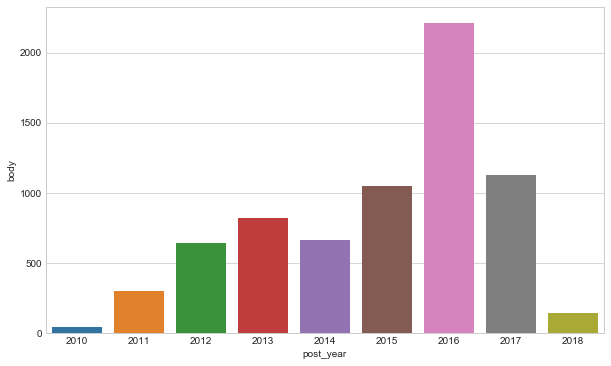

In [24]:
plt.figure(figsize = (10, 6))
sns.barplot('post_year', 'body', data= df_per_year)


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


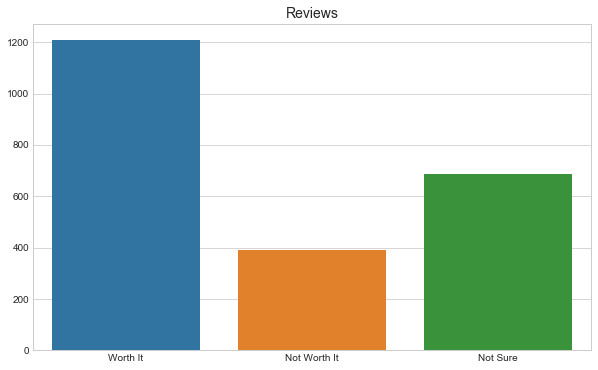

In [25]:
plt.figure(figsize = (10, 6))
sns.barplot(y= worthit, x= ["Worth It", "Not Worth It", "Not Sure"])
plt.title('Reviews', fontsize = 14)
plt.show()



In [207]:
from collections import Counter
import sys
from nltk.util import ngrams


def most_common_word_phrases(text_corpus, ngram_length=2, extra_stopwords = None,
                             nouns_only=False, doc_count=False):
    from textblob import TextBlob

    if extra_stopwords is None:
        extra_stopwords = []
    
    stop = nltk_stopwords
    stop += [".", ",", "(", ")",'"', '\\n']
    stop += extra_stopwords
    
    counter = Counter()

    for i, doc in enumerate(text_corpus):

        if i% 25000 == 0:
            print (sys.stderr, "Processing %i" % i)
        
        doc = doc.replace("\\n", " ")
        
        if ngram_length != 'noun_phrases' and nouns_only:
            words = [w for w,postag in TextBlob(doc).tags if postag == 'NN']
            words = [w for w in words if w not in stop]
        elif ngram_length != 'noun_phrases':
            words = TextBlob(doc).words
            words = [w for w in words if w not in stop]

        if ngram_length == 'noun_phrases':
            def is_legit(np):
                for stopw in stop:
                    if stopw in np:
                        return False
                return True
            N_grams = [np for np in TextBlob(doc).noun_phrases if is_legit(np)]
        else:
            N_grams = ngrams(words,ngram_length)

        if doc_count:
            N_grams = list(set(N_grams))
        
        for gram in N_grams:
            counter[gram] += 1

    #pprint( counter.most_common(100))
    return counter.most_common(250)

In [48]:
most_common_word_phrases(df['body'])

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

[(('It', "'s"), 841),
 (('ca', "n't"), 671),
 (('could', "n't"), 425),
 (('2', 'weeks'), 294),
 (('3', 'months'), 287),
 (('3', 'weeks'), 262),
 (('see', 'difference'), 258),
 (('So', 'far'), 246),
 (('10', 'minutes'), 240),
 (("n't", 'feel'), 233),
 (('wo', "n't"), 227),
 (('diet', 'exercise'), 222),
 (('The', 'first'), 219),
 (('Cool', 'Sculpting'), 207),
 (('2', 'months'), 205),
 (('two', 'weeks'), 198),
 (("n't", 'know'), 197),
 (("'m", 'going'), 193),
 (('4', 'weeks'), 192),
 (("n't", 'see'), 191),
 (("n't", 'wait'), 184),
 (("n't", 'really'), 179),
 (("n't", 'think'), 179),
 (("n't", 'want'), 174),
 (('muffin', 'top'), 170),
 (('5', 'minutes'), 169),
 (('first', 'time'), 168),
 (("n't", 'even'), 167),
 (("n't", 'hurt'), 166),
 (("n't", 'bad'), 163),
 (('much', 'better'), 163),
 (('large', 'applicator'), 161),
 (("'s", 'office'), 160),
 (("'m", 'hoping'), 160),
 (('highly', 'recommend'), 155),
 (('days', 'ago'), 151),
 (('6', 'weeks'), 150),
 (('last', 'night'), 148),
 (('years', 

## Topic Modelling

### NMF

In [191]:
#stop words dictionary
nltk_stopwords = stopwords.words('english')+["did", "inner", "outer", "arms","treatment", "procedure", "I", "done", "coolsculpting", "area", "day", 'fat', "cool sculpting", "pain", "results", "get", "would", "sculpting", "like", "abdomen","handles", "stomach", "lower", "love", "thighs", "legs","per", "cool","made", "went", "go", "coolsculpt", "belly", "still", "little","dont","pron", "handle", "result", "i'm", "upper", "one", "-PRON-", "muffin", "top"]

no_features = 1000
no_topics = 5
no_top_words = 20


In [52]:
data = [post.lower() for post in df['body']]
len(data)

7027

In [53]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z0-9@]", " ", text) # remove everything except numbers, hashtags, and @
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [54]:
df['body_lem'] = df['body'].apply(get_tokens)

In [28]:
lmtzr = WordNetLemmatizer()


lem_data = [lmtzr.lemmatize(post) for post in data]
#lem_data = [lmtzr.lemmatize(lmtzr.lemmatize(post,pos='v'),pos='n') for w in data]
data = lem_data

df['body'] = lem_data

In [49]:
def print_top_words(model, feature_names, n_top_words = 50):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [58]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words= nltk_stopwords)
tfidf = tfidf_vectorizer.fit_transform(df['body_lem'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

print_top_words(nmf, tfidf_feature_names, 50)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):



Topic #0:
feel, bad, numb, take, minute, today, first, massage, applicator, low, hour, painful, uncomfortable, side, start, hurt, really, wear, help, bruise, time, night, swell, bit, sore, much, abdoman, sleep, skin, say, good, touch, last, feeling, swollen, back, suction, pretty, right, also, think, post, machine, use, discomfort, sensation, cold, read, fine, tender

Topic #1:
see, change, month, difference, picture, think, yet, say, wait, notice, post, really, pic, much, since, know, hop, worth, start, look, tell, definitely, maybe, slight, money, second, another, take, sure, numbness, mark, may, already, noticeable, thigh, bit, improvement, hope, excited, update, well, next, feel, today, arm, even, small, expect, far, continue

Topic #2:
work, dr, lose, weight, want, time, good, back, year, look, thigh, recommend, make, exercise, great, happy, office, try, staff, diet, body, rid, decide, month, always, could, even, money, tummy, never, surgery, give, treat, experience, well, abdoma

### LDA

In [156]:
# with tf-idf
def get_topics_lda_tfidf(df, n_topics):   
    vect = TfidfVectorizer(max_df = 0.95, max_features = 1000,
                                 min_df = 5, stop_words = nltk_stopwords,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(df)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    #print topic words
    print_top_words(lda, vocab)
    
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [63]:
all_lda_tfidf, all_doc_topics_tfidf, all_prepared_tfidf = get_topics_lda_tfidf(df['body_lem'], 5)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)



Topic #0:
feel, take, week, numb, bad, today, first, good, see, time, post, minute, low, start, back, really, swell, work, much, help, massage, say, painful, side, think, bit, hour, wear, bruise, hurt, night, uncomfortable, abdoman, applicator, sore, sleep, last, swollen, touch, also, two, look, feeling, experience, skin, numbness, swelling, yet, nothing, right

Topic #1:
week, picture, pic, sorry, add, take, picture take, pleased, far, itch, update, hi, finally, almost, post, guy, quite, today, post picture, flanks, really, last, take picture, late, week post, morning, lean, slight, type, odd, way, lol, hard, want, low, find, look, review, try, month, use, wait, well, good, abdoman, yesterday, photo, reason, lady, final

Topic #2:
pic, today, compare, take, update, low abdominal, abdominal, flank, low, take pic, friday, want, back, real, feel, morning, night, ready, week, saturday, month, work, cardio, good, see, find, time, last, decrease, include, cs, lipo, numbness, far, reduction

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [64]:
pyLDAvis.display(all_prepared_tfidf)

In [222]:
# with count vectorizer
def get_topics_lda(df, n_topics):   
    count_vect = CountVectorizer(analyzer = "word",
                                       stop_words = nltk_stopwords,
                                       max_features = 1000, 
                                       max_df = 0.5,
                                       min_df = 2,
                                ngram_range = (1,3))
    matrix = count_vect.fit_transform(df)
    vocab = count_vect.get_feature_names()


    # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
                learning_method='online', learning_offset=50., max_iter=10,
                random_state=0)
    
    doc_topic_dists = lda.fit_transform(matrix)
    
    # print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [215]:
all_lda, all_doc_topics, all_prepared = get_topics_lda(df['body'], 5)


Topic #0:
see, weeks, difference, post, week, month, months, change, since, think, photos, pictures, two, second, time, much, pics, first, really, abs, seeing, back, next, feel, sure, say, look, know, far, well, flanks, wait, today, days, going, another, changes, last, happy, better, mark, side, definitely, hoping, worth, notice, also, even, good, yet

Topic #1:
dr, time, back, areas, recommend, office, great, could, work, feel, months, see, treatments, staff, money, first, told, happy, decided, experience, always, rid, really, even, surgery, never, wanted, body, weeks, years, two, well, comfortable, going, took, said, amazing, tummy, best, got, treated, try, doctor, good, also, lipo, worth, anyone, much, definitely

Topic #2:
weight, lost, exercise, diet, lbs, lose, pounds, inches, waist, back, body, right, since, much, work, arm, months, eating, even, look, money, loss, want, left, gained, better, healthy, eat, also, 10, 20, inch, areas, size, fit, thigh, lot, around, shape, hard, s

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [217]:
pyLDAvis.display(all_prepared)

In [223]:
all_lda1, all_doc_topics1, all_prepared1 = get_topics_lda(df[(df['worthit'] == 'Not Worth It')]['body'], 4)



Topic #0:
see, weeks, month, post, photos, changes, change, months, lipo, said, think, difference, pictures, yet, look, today, first, hoping, next, seen, second, update, since, also, week, hope, maybe, taken, days, mark, wait, feel, notice, weeks post, told, time, later, op, month mark, know, appointment, seeing, nothing, noticeable, waiting, money, zeltiq, pants, sure, either

Topic #1:
side, patients, hip, pah, zeltiq, effect, side effect, patient, skin, uneven, frozen, right, left side, bigger, two, began, machine, nice, beware, never, right side, surgery, following, huge, weeks, ever, left, procedures, please, way, told, person, though, visible, massage, ok, got, far, leg, spa, problem, flatter, caused, stick, people, cold, best, fitting, course, loose

Topic #2:
money, see, back, months, time, work, much, first, weeks, even, really, days, two, told, could, feel, since, going, said, weight, week, also, say, change, never, think, areas, difference, well, know, good, got, nothing, w

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [224]:
pyLDAvis.display(all_prepared1)

In [81]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [428]:
# categorize reviews by most probable topic
df['topic_LDA'] = get_doc_topics(all_doc_topics)

In [429]:
df_not_worthit = df[df['worthit'] == 'Not Worth It']
df_not_worthit['topic_notworthit'] = get_doc_topics(all_doc_topics1)

In [430]:
most_common_word_phrases(df_not_worthit['body'], 4)

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

[(('Do', "n't", 'waste', 'money'), 4),
 (('It', "'s", '1', 'month'), 3),
 (('takes', '4', 'months', 'see'), 3),
 (('The', 'worst', 'part', 'massage'), 3),
 (('To', 'make', 'matters', 'worse'), 3),
 (('It', "'s", '2', 'weeks'), 3),
 (("'s", '3', 'months', 'since'), 3),
 (("n't", 'think', "'s", 'worth'), 3),
 (('If', 'sounds', 'good', 'true'), 3),
 (('waited', 'waited', 'waited', 'Nothing'), 2),
 (('without', 'ice', 'pack', "'m"), 2),
 (("n't", 'think', "'s", 'related'), 2),
 (('ca', "n't", 'wait', 'see'), 2),
 (("n't", 'wait', 'see', 'look'), 2),
 (("n't", 'see', 'positive', 'changes'), 2),
 (("n't", 'see', 'yet', 'know'), 2),
 (('told', 'takes', '3', 'months'), 2),
 (('feel', 'wasted', 'money', 'could'), 2),
 (('wasted', 'money', 'could', 'gone'), 2),
 (('money', 'could', 'gone', 'toward'), 2),
 (('could', 'gone', 'toward', 'something'), 2),
 (('gone', 'toward', 'something', 'else'), 2),
 (('It', "'s", '5', 'months'), 2),
 (("'s", '5', 'months', 'absolutely'), 2),
 (('could', 'last', '

In [431]:
most_common_word_phrases(df_not_worthit['body'], 3)

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

[(("n't", 'waste', 'money'), 9),
 (('waste', 'time', 'money'), 8),
 (('told', 'perfect', 'candidate'), 8),
 (('It', "'s", 'week'), 8),
 (("n't", 'see', 'difference'), 7),
 (('Not', 'worth', 'money'), 7),
 (('3', 'months', 'later'), 7),
 (('could', "n't", 'sleep'), 6),
 (("n't", 'think', "'s"), 6),
 (('read', 'many', 'reviews'), 6),
 (('feel', 'wasted', 'money'), 6),
 (("n't", 'think', 'worth'), 6),
 (('ca', "n't", 'see'), 6),
 (('4', 'months', 'later'), 6),
 (('It', "n't", 'work'), 6),
 (('hard', 'earned', 'money'), 5),
 (('without', 'ice', 'pack'), 5),
 (("n't", 'waste', 'time'), 5),
 (('It', "'s", '1'), 5),
 (("n't", 'think', "'ll"), 5),
 (('3', 'months', 'ago'), 5),
 (('said', 'good', 'candidate'), 5),
 (('The', 'worst', 'part'), 5),
 (('mini', 'tummy', 'tuck'), 5),
 (("'s", '3', 'months'), 5),
 (('It', "'s", '2'), 5),
 (("n't", 'know', "'s"), 5),
 (('3', 'months', 'since'), 5),
 (('Do', "n't", 'waste'), 5),
 (('laser', 'hair', 'removal'), 5),
 (('told', 'great', 'candidate'), 5),
 

In [432]:
most_common_word_phrases(df_not_worthit['body'], 2)

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

[(('It', "'s"), 115),
 (('ca', "n't"), 72),
 (('3', 'months'), 54),
 (('waste', 'money'), 49),
 (("n't", 'see'), 46),
 (("n't", 'work'), 46),
 (('2', 'months'), 45),
 (("n't", 'know'), 41),
 (('2', 'weeks'), 40),
 (('4', 'months'), 36),
 (('could', "n't"), 35),
 (('see', 'difference'), 34),
 (("n't", 'think'), 34),
 (('Cool', 'Sculpting'), 33),
 (('ice', 'pack'), 31),
 (('first', 'time'), 29),
 (('months', 'later'), 29),
 (('wo', "n't"), 28),
 (('3', 'weeks'), 28),
 (("n't", 'even'), 27),
 (('pretty', 'much'), 26),
 (('months', 'since'), 26),
 (('diet', 'exercise'), 25),
 (('tummy', 'tuck'), 24),
 (("n't", 'want'), 24),
 (("'m", 'hoping'), 23),
 (("n't", 'feel'), 22),
 (('6', 'weeks'), 21),
 (("'m", 'sure'), 20),
 (('two', 'weeks'), 20),
 (("'m", 'going'), 19),
 (('side', 'effects'), 18),
 (('weeks', 'post'), 18),
 (('see', 'changes'), 18),
 (('come', 'back'), 18),
 (('perfect', 'candidate'), 18),
 (('lot', 'money'), 18),
 (('month', 'mark'), 17),
 (('three', 'months'), 17),
 (('months

In [433]:
# get_stopwords(small_paragraph1_data, only_keep=100)

               
common_phrases = most_common_word_phrases(df_not_worthit['body'],
                                          ngram_length= 4,
                                          extra_stopwords=nltk_stopwords,
                                          nouns_only=False,
                                          doc_count=True)
common_phrases

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator '

[(('Do', "n't", 'waste', 'money'), 4),
 (('It', "'s", '1', 'month'), 3),
 (('takes', '4', 'months', 'see'), 3),
 (('The', 'worst', 'part', 'massage'), 3),
 (('To', 'make', 'matters', 'worse'), 3),
 (('It', "'s", '2', 'weeks'), 3),
 (("'s", '3', 'months', 'since'), 3),
 (("n't", 'think', "'s", 'worth'), 3),
 (('If', 'sounds', 'good', 'true'), 3),
 (('waited', 'waited', 'waited', 'Nothing'), 2),
 (('without', 'ice', 'pack', "'m"), 2),
 (('ca', "n't", 'wait', 'see'), 2),
 (("n't", 'wait', 'see', 'look'), 2),
 (("n't", 'see', 'positive', 'changes'), 2),
 (("n't", 'see', 'yet', 'know'), 2),
 (('feel', 'wasted', 'money', 'could'), 2),
 (('told', 'takes', '3', 'months'), 2),
 (('wasted', 'money', 'could', 'gone'), 2),
 (('gone', 'toward', 'something', 'else'), 2),
 (('money', 'could', 'gone', 'toward'), 2),
 (('could', 'gone', 'toward', 'something'), 2),
 (("'s", '5', 'months', 'absolutely'), 2),
 (('It', "'s", '5', 'months'), 2),
 (('could', 'last', '2', 'weeks'), 2),
 (('another', '2', 'mon

In [434]:
from functools import partial

def entropy(phrase_count, corpus_size=100):
    p = float(phrase_count)/corpus_size
    return -p*np.log(p)

def entropy_of_tup(tup, corpsize=1000):
    ngram, count = tup
    return (entropy(count, corpsize), ngram)

def get_entropies_of_word_counts(word_counts, corpsize=1000):
    ent = partial(entropy_of_tup, corpsize = corpsize)
    return sorted(map(entropy_of_tup, word_counts), reverse=True)

def get_stopwords(corpus, only_keep = 1000, n=1, corpsize=1000):
    word_counts = most_common_word_phrases(corpus, n, doc_count=True)
    entropies = get_entropies_of_word_counts(word_counts, corpsize=corpsize)
    belowtop1K = entropies[only_keep:]
    return [w for ent, w in belowtop1K]

In [435]:
stop_grams = get_stopwords(df_not_worthit['body'][:1000], only_keep=50, n=4, corpsize=10)
common_phrases = most_common_word_phrases(df_not_worthit['body'][:1000], extra_stopwords=nltk_stopwords)
for ngram, count in common_phrases:
    if ngram not in stop_grams:
        print (ngram)

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: generator '

<ipykernel.iostream.OutStream object at 0x10c21e780> Processing 0


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator '

('It', "'s")
('ca', "n't")
('3', 'months')
('waste', 'money')
("n't", 'see')
("n't", 'work')
('2', 'months')
("n't", 'know')
('2', 'weeks')
('4', 'months')
('could', "n't")
('see', 'difference')
("n't", 'think')
('Cool', 'Sculpting')
('ice', 'pack')
('first', 'time')
('months', 'later')
('wo', "n't")
('3', 'weeks')
("n't", 'even')
('pretty', 'much')
('months', 'since')
('diet', 'exercise')
('tummy', 'tuck')
("n't", 'want')
("'m", 'hoping')
("n't", 'feel')
('6', 'weeks')
("'m", 'sure')
('two', 'weeks')
("'m", 'going')
('side', 'effects')
('weeks', 'post')
('see', 'changes')
('come', 'back')
('perfect', 'candidate')
('lot', 'money')
('month', 'mark')
('three', 'months')
('months', 'ago')
('good', 'candidate')
('The', 'first')
('4', 'weeks')
('weight', 'loss')
('even', 'though')
('1', 'month')
('months', 'see')
('lost', 'weight')
('Ideal', 'Image')
("n't", 'really')
('8', 'weeks')
('years', 'old')
("n't", 'seem')
('3', 'days')
("n't", 'waste')
('waste', 'time')
('Not', 'sure')
("'s", 'wor

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: generator 'ngrams' raised StopIteration


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


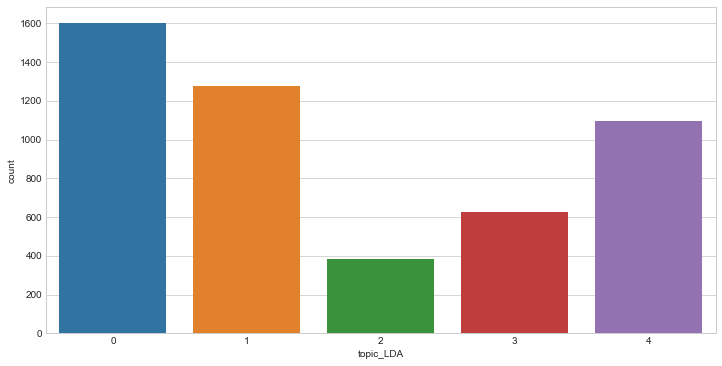

In [436]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


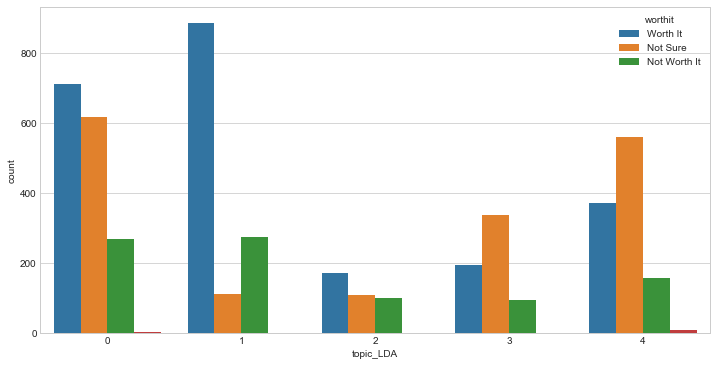

In [437]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df, hue = "worthit")

#### Organize periods

In [438]:
df['days_from_procedure'] = df[df['days_from_procedure'] <= 700]['days_from_procedure']
df['weeks_from_procedure'] = round(df['days_from_procedure'] / 7,0)
df['biweekly'] = round(df['days_from_procedure'] / 14,0)
df = df[df['weeks_from_procedure'] >0]
df = df[[df['biweekly'] >0] and df['biweekly'] < 30]

In [439]:
## aggregate days by month
def get_months(day):
    if day >= 365:
        return "over 1 year"
    elif day >= 334:
        return "11"
    elif day >= 303:
        return "10"
    elif day >= 272:
        return "11"
    elif day >= 241:
        return "09"
    elif day >= 211:
        return "08"
    elif day >= 181:
        return "07"
    elif day >= 151:
        return "06"
    elif day >= 121:
        return "05"
    elif day >= 91:
        return "04"
    elif day >= 60:
        return "03"
    elif day >= 30:
        return "02"
    else:
        return "01"

In [440]:
df['months_from_procedure'] = df['days_from_procedure'].apply(get_months) 

In [441]:
## aggregate days by periods
def get_period(day):
    if day >= 365:
        return "+1 year"
    elif day >= 210:
        return "month 6"
    elif day >= 180:
        return "month 5"
    elif day >= 126:
        return "week 19"
    elif day >= 119:
        return "week 18"
    elif day >= 112:
        return "week 17"
    elif day >= 105:
        return "week 16"
    elif day >= 98:
        return "week 15"
    elif day >= 91:
        return "week 14"
    elif day >= 84:
        return "week 13"
    elif day >= 77:
        return "week 12"
    elif day >= 70:
        return "week 11"
    elif day >= 63:
        return "week 10"
    elif day >= 56:
        return "week 9"
    elif day >= 49:
        return "week 8"
    elif day >= 42:
        return "week 7"
    elif day >= 35:
        return "week 6"
    elif day >= 28:
        return "week 5"
    elif day >= 21:
        return "week 4"
    elif day >= 14:
        return "week 3"
    elif day >= 7:
        return "week 2"
    else:
        return "week 1"

In [442]:
df['period'] = df['days_from_procedure'].apply(get_period) 

In [443]:
df_sorted = df.sort_values(by=['days_from_procedure'])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


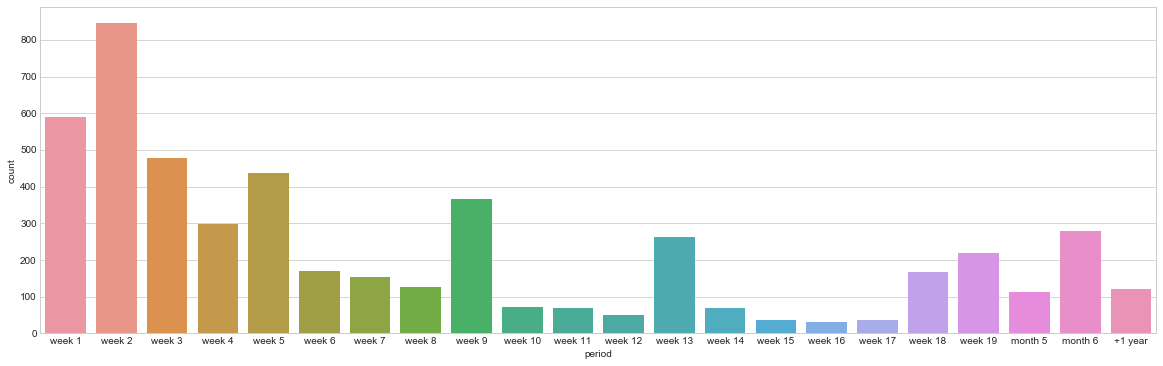

In [444]:
plt.figure(figsize = (20,6))
sns.countplot(df_sorted['period'])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


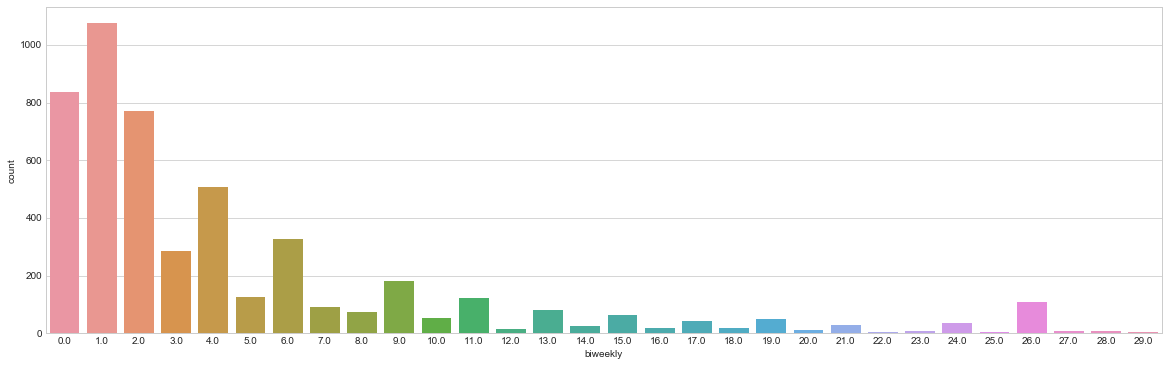

In [445]:
plt.figure(figsize = (20,6))
sns.countplot(df_sorted['biweekly'])

## Sentiment Analysis

In [446]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [447]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [TextBlob(x).sentiment[0] for x in sents]

def get_vader_sentiment(text):
    """Return vaderSentiment score for text."""
    try:
        return vaderSentiment(text)['compound']
    except:
        return 0

In [448]:
df['sentences'] = df['body'].apply(get_sentences)

In [449]:
df['sentiment_scores'] = df['sentences'].apply(get_polarity)

In [450]:
df['avg_sentiment'] = df['sentiment_scores'].apply(np.mean)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [451]:
df_sentiment = df.groupby(['days_from_procedure','avg_sentiment','worthit']).mean()
df_sentiment = df_sentiment.reset_index()
df_sentiment_not_worthit = df_sentiment[df_sentiment['worthit'] == "Not Worth It"]
df_sentiment_worthit = df_sentiment[df_sentiment['worthit'] == "Worth It"]
df_sentiment_not_sure = df_sentiment[df_sentiment['worthit'] == "Not Sure"]

Text(0.5,1,'Sentiment of Posts')

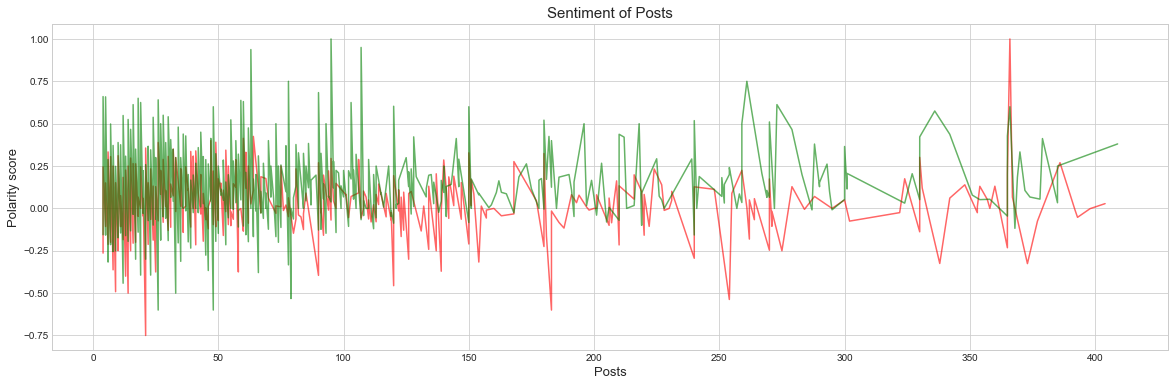

In [452]:
## plot sentiment analysis evolution
plt.figure(figsize=(20,6))
#plt.plot(df_sentiment['days_from_procedure'], df_sentiment['avg_sentiment'])
plt.plot(df_sentiment_not_worthit['days_from_procedure'], df_sentiment_not_worthit['avg_sentiment'],'r-', alpha=0.6, label = "reviews marked as not worthit")
plt.plot(df_sentiment_worthit['days_from_procedure'], df_sentiment_worthit['avg_sentiment'],'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Posts", fontsize=13)
plt.title("Sentiment of Posts", fontsize=15)

In [453]:
## moving average
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

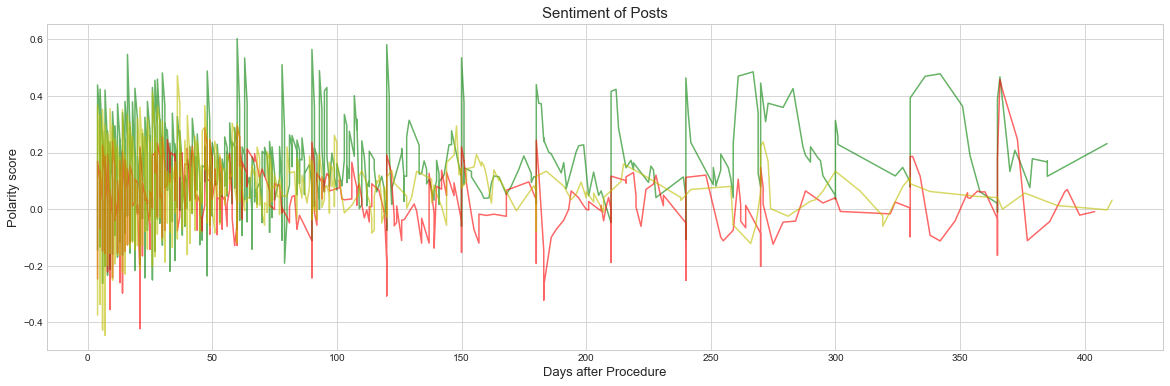

In [454]:
worthit_MA = movingaverage(df_sentiment_worthit['avg_sentiment'],3)
not_worthit_MA = movingaverage(df_sentiment_not_worthit['avg_sentiment'],3)
not_sure_MA = movingaverage(df_sentiment_not_sure['avg_sentiment'],3)

## plot sentiment analysis evolution
plt.figure(figsize=(20,6))

plt.plot(df_sentiment_worthit['days_from_procedure'][len(df_sentiment_worthit['days_from_procedure'])-len(worthit_MA):],worthit_MA,'g-', alpha=0.6)
plt.plot(df_sentiment_not_worthit['days_from_procedure'][len(df_sentiment_not_worthit['days_from_procedure'])-len(not_worthit_MA):],not_worthit_MA,'r-', alpha=0.6)
plt.plot(df_sentiment_not_sure['days_from_procedure'][len(df_sentiment_not_sure['days_from_procedure'])-len(not_sure_MA):],not_sure_MA,'y-', alpha=0.6)


#plt.plot(df_sentiment_not_worthit['days_from_procedure'], not_worthit_MA,'r-', alpha=0.6, label = "reviews marked as not worthit")
#plt.plot(df_sentiment_worthit['days_from_procedure'], worthit_MA,'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Days after Procedure", fontsize=13)
plt.title("Sentiment of Posts", fontsize=15)

plt.show()

#### Average Sentiment per Day

In [374]:
df_sentiment_not_worthit1 = df_sentiment_not_worthit.groupby(['days_from_procedure']).mean().reset_index()
df_sentiment_worthit1 = df_sentiment_worthit.groupby(['days_from_procedure']).mean().reset_index()
df_sentiment_not_sure1 = df_sentiment_not_sure.groupby(['days_from_procedure']).mean().reset_index()

Text(0.5,1,'Average Sentiment per Day')

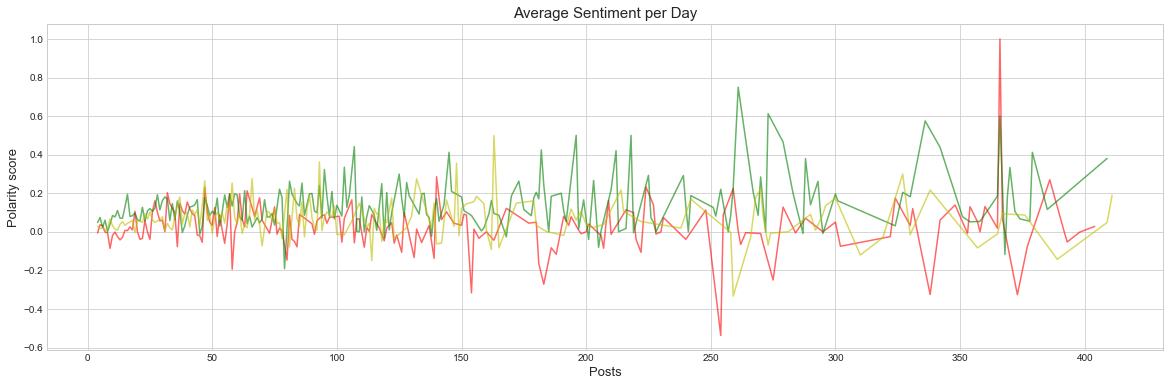

In [249]:
## plot sentiment analysis evolution
plt.figure(figsize=(20,6))
#plt.plot(df_sentiment['days_from_procedure'], df_sentiment['avg_sentiment'])
plt.plot(df_sentiment_not_worthit1['days_from_procedure'], df_sentiment_not_worthit1['avg_sentiment'],'r-', alpha=0.6, label = "reviews marked as not worthit")
plt.plot(df_sentiment_worthit1['days_from_procedure'], df_sentiment_worthit1['avg_sentiment'],'g-', alpha=0.6, label = "reviews marked as worthit")
plt.plot(df_sentiment_not_sure1['days_from_procedure'], df_sentiment_not_sure1['avg_sentiment'],'y-', alpha=0.6, label = "reviews marked as not sure")


plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Posts", fontsize=13)
plt.title("Average Sentiment per Day", fontsize=15)

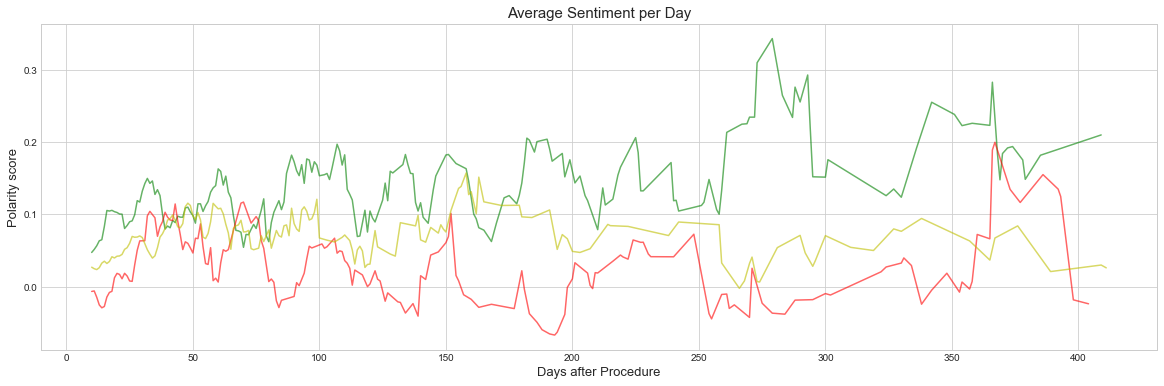

In [250]:
worthit_MA1 = movingaverage(df_sentiment_worthit1['avg_sentiment'],7)
not_worthit_MA1 = movingaverage(df_sentiment_not_worthit1['avg_sentiment'],7)
not_sure_MA1 = movingaverage(df_sentiment_not_sure1['avg_sentiment'],7)

## plot sentiment analysis evolution
plt.figure(figsize=(20,6))

plt.plot(df_sentiment_worthit1['days_from_procedure'][len(df_sentiment_worthit1['days_from_procedure'])-len(worthit_MA1):],worthit_MA1,'g-', alpha=0.6)
plt.plot(df_sentiment_not_worthit1['days_from_procedure'][len(df_sentiment_not_worthit1['days_from_procedure'])-len(not_worthit_MA1):],not_worthit_MA1,'r-', alpha=0.6)
plt.plot(df_sentiment_not_sure1['days_from_procedure'][len(df_sentiment_not_sure1['days_from_procedure'])-len(not_sure_MA1):],not_sure_MA1,'y-', alpha=0.6)


#plt.plot(df_sentiment_not_worthit['days_from_procedure'], not_worthit_MA,'r-', alpha=0.6, label = "reviews marked as not worthit")
#plt.plot(df_sentiment_worthit['days_from_procedure'], worthit_MA,'g-', alpha=0.6, label = "reviews marked as worthit")
plt.ylabel("Polarity score", fontsize=13)
plt.xlabel("Days after Procedure", fontsize=13)
plt.title("Average Sentiment per Day", fontsize=15)

plt.show()

### Set thresholds for negative and positive

In [455]:
def sentiment_threshold(sentiment):
    if sentiment >= 0.3:
        return "positive"
    elif sentiment <= -0.2:
        return "negative"
    else:
        return "neutral"
    
df['sentiment'] = df['avg_sentiment'].apply(sentiment_threshold)

Text(0.5,1,'Sentiment Distribution')

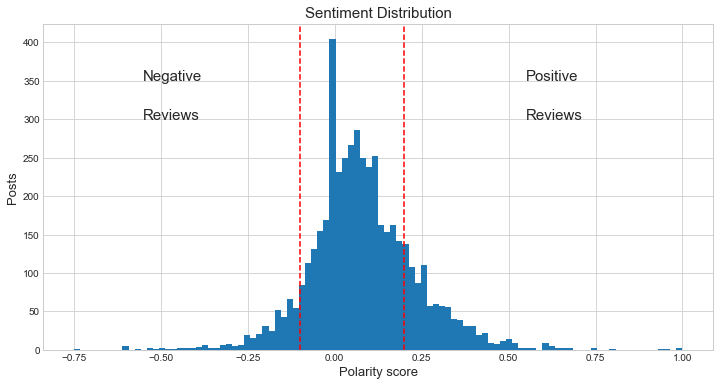

In [456]:
plt.figure(figsize=(12,6))
#sns.plot(df[df['body'] != ""]['avg_sentiment'])
plt.hist(df[df['body'] != ""]['avg_sentiment'], bins = 100) # ignore NaN's
plt.axvline(x=-0.1, color="r",linestyle="dashed")
plt.axvline(x=0.2, color="r",linestyle="dashed")

plt.text(0.55, 350, "Positive", fontsize=15)
plt.text(0.55, 300, "Reviews", fontsize=15)
plt.text(-0.55, 350, "Negative", fontsize=15)
plt.text(-0.55, 300, "Reviews", fontsize=15)

plt.xlabel("Polarity score", fontsize=13)
plt.ylabel("Posts", fontsize=13)
plt.title("Sentiment Distribution", fontsize=15)

#### Save DataFrame

In [457]:
pickle.dump(df, open("reviews_topics_coosculpting.pickle",'wb'))

In [458]:
df.to_csv("reviews_topics_coosculpting.csv", encoding='utf-8', index=False)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


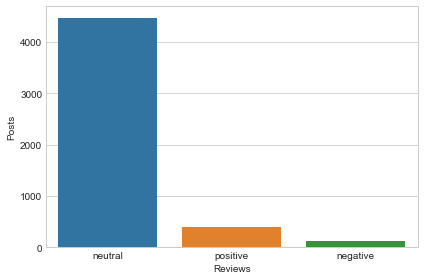

In [459]:
sns.countplot(df['sentiment'])
plt.xlabel("Reviews")
plt.ylabel("Posts")
#plt.ylim(0,4000)
plt.tight_layout()

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


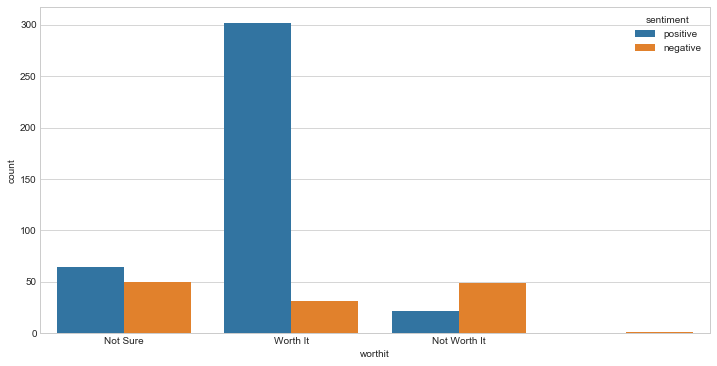

In [460]:
plt.figure(figsize=(12,6))
sns.countplot(df[df['sentiment'] != 'neutral']['worthit'], hue = df[df['sentiment'] != 'neutral']['sentiment'])

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


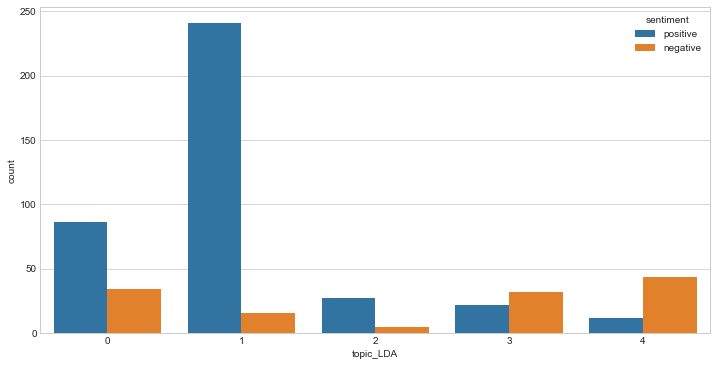

In [461]:
plt.figure(figsize=(12,6))
sns.countplot(df[df['sentiment'] != 'neutral']['topic_LDA'], hue = df[df['sentiment'] != 'neutral']['sentiment'])
#sns.countplot(df['topic'], hue = df['sentiment'])

In [462]:
df_not_worthit.head()

body  \
9   I wanted to get rid of the noticeable pouch in my abdominal area. After I prepaid for 6 areas/cycles cost was over 3,200.  I found it very difficult to get an appointment. I did NOT see any improvement and I am still experiences numbness after the procedure. I would not recommend this place because no one seemed to be concerned about the difficulties that I was experiencing after the procedure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
16  I was very optimistic about having the procedure. I was excited that there was no down time and not exposing myself to the danger of going under. I bought 10 sessions and was looking forward to the new improved me. I had my stomach done first in two sessions with the large applicator. It was not painful at all. I felt fine through out the whole procedure with out any side effects. Yes, it was very cold and numbing on my stomach but not unbearable at all. The massage after was not painful. I left with a waist trainer type body suit. I did not have any swelling or bruising following the procedure. I was told it will take 12 weeks to see the results but it was common to see results as soon as 4-8 weeks. The next week I did both of my arms. I had the same experience as I did with my stomach. I was so excited I was finally going to have the kind of arms that would look great in a strapless dress. So I waited and waited and waited. Nothing! They only took pictures at the office, no measurements. I took measurements before and after for my own records. I did not get any results in my stomach area or my arms. I felt like I was scammed! Money spent and wasted for nothing! I had two more sessions for my arms left but I decided to get a refund for those two sessions since I did not get any results. I did not want to waste any more of my hard earned money. Remember, I have 4 kids. I finally spent money on myself for something that was not necessary but something that would make me look better and feel better. I have always put my children first and put off doing something like this because the money can go towards something that is more valuable like college! The company I used was going to uncharge me for the 8

In [470]:
df_period_neg = df_not_worthit.groupby(['months_from_procedure','topic_notworthit'])
df_count_posts_neg = df_period_neg.topic_LDA.count()
df_count_posts_neg = df_count_posts_neg.unstack()

In [464]:
df_period = df.groupby(['months_from_procedure','topic_LDA'])
df_count_posts = df_period.topic_LDA.count()
df_count_posts = df_count_posts.unstack()

### Topics Evolution over time

In [471]:
df_count_posts_neg

topic_notworthit          0    1      2     3
months_from_procedure                        
01                     56.0  2.0  182.0  67.0
02                     45.0  2.0  76.0   9.0 
03                     12.0  2.0  98.0  NaN  
04                     10.0  1.0  61.0   1.0 
05                     2.0   1.0  57.0  NaN  
06                     4.0  NaN   32.0  NaN  
07                     6.0   2.0  27.0   1.0 
08                     2.0   1.0  24.0  NaN  
09                    NaN    1.0  27.0  NaN  
10                    NaN   NaN   15.0  NaN  
11                     5.0  NaN   13.0  NaN  
over 1 year           NaN    1.0  49.0   2.0

In [416]:
df_count_posts

topic_LDA                  0      1     2      3      4
months_from_procedure                                  
01                     631.0  215.0  99.0  558.0  817.0
02                     468.0  140.0  80.0  44.0   101.0
03                     230.0  390.0  55.0  13.0   76.0 
04                     104.0  134.0  45.0  3.0    38.0 
05                     53.0   86.0   28.0  3.0    17.0 
06                     26.0   59.0   15.0  1.0    8.0  
07                     23.0   48.0   13.0  2.0    10.0 
08                     19.0   33.0   7.0   1.0    5.0  
09                     17.0   37.0   9.0   1.0    5.0  
10                     3.0    25.0   5.0  NaN     5.0  
11                     18.0   26.0   12.0 NaN     4.0  
over 1 year            12.0   82.0   15.0  2.0    11.0

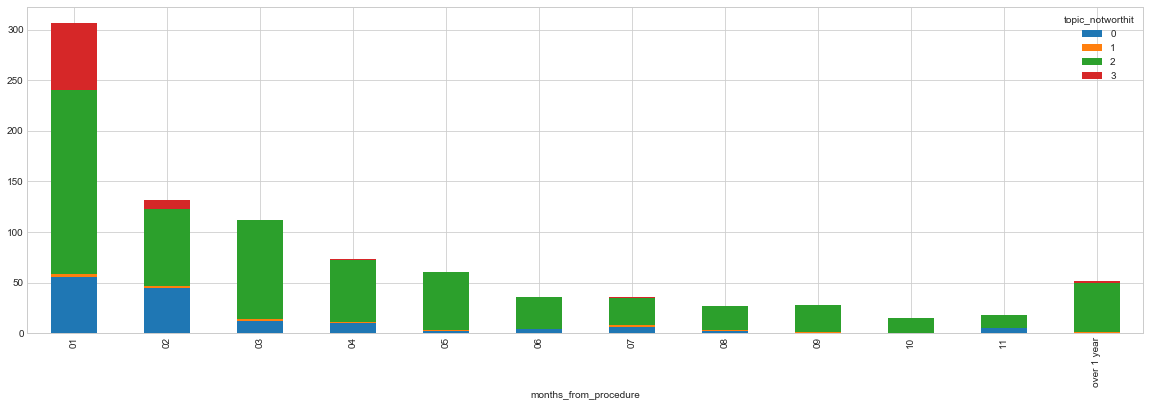

In [472]:
plt.figure(figsize=(20,6))

df_count_posts_neg.plot(kind='bar', stacked=True, figsize=(20,6))

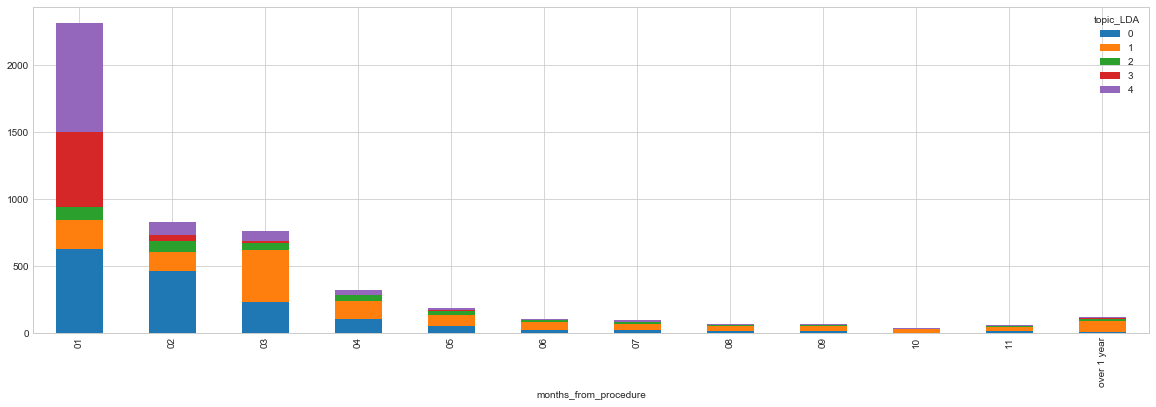

In [417]:
plt.figure(figsize=(20,6))

df_count_posts.plot(kind='bar', stacked=True, figsize=(20,6))

In [473]:
# We need to transform the data from raw data to percentage (fraction)
topic_perc_neg = df_count_posts_neg.divide(df_count_posts_neg.sum(axis=1), axis=0)
topic_perc_neg

topic_notworthit              0         1         2         3
months_from_procedure                                        
01                     0.182410  0.006515  0.592834  0.218241
02                     0.340909  0.015152  0.575758  0.068182
03                     0.107143  0.017857  0.875000 NaN      
04                     0.136986  0.013699  0.835616  0.013699
05                     0.033333  0.016667  0.950000 NaN      
06                     0.111111 NaN        0.888889 NaN      
07                     0.166667  0.055556  0.750000  0.027778
08                     0.074074  0.037037  0.888889 NaN      
09                    NaN        0.035714  0.964286 NaN      
10                    NaN       NaN        1.000000 NaN      
11                     0.277778 NaN        0.722222 NaN      
over 1 year           NaN        0.019231  0.942308  0.038462

In [418]:
# We need to transform the data from raw data to percentage (fraction)
topic_perc = df_count_posts.divide(df_count_posts.sum(axis=1), axis=0)
topic_perc

topic_LDA                     0         1         2         3         4
months_from_procedure                                                  
01                     0.271983  0.092672  0.042672  0.240517  0.352155
02                     0.561825  0.168067  0.096038  0.052821  0.121248
03                     0.301047  0.510471  0.071990  0.017016  0.099476
04                     0.320988  0.413580  0.138889  0.009259  0.117284
05                     0.283422  0.459893  0.149733  0.016043  0.090909
06                     0.238532  0.541284  0.137615  0.009174  0.073394
07                     0.239583  0.500000  0.135417  0.020833  0.104167
08                     0.292308  0.507692  0.107692  0.015385  0.076923
09                     0.246377  0.536232  0.130435  0.014493  0.072464
10                     0.078947  0.657895  0.131579 NaN        0.131579
11                     0.300000  0.433333  0.200000 NaN        0.066667
over 1 year            0.098361  0.672131  0.122951  0.016393  0.090164

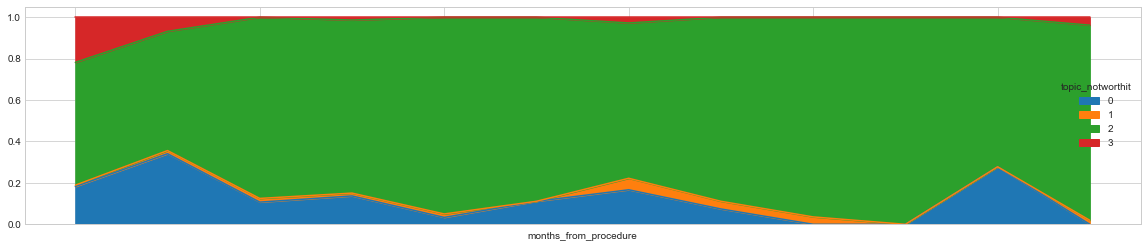

In [474]:
topic_perc_neg[:18].plot.area(figsize=(20,4))

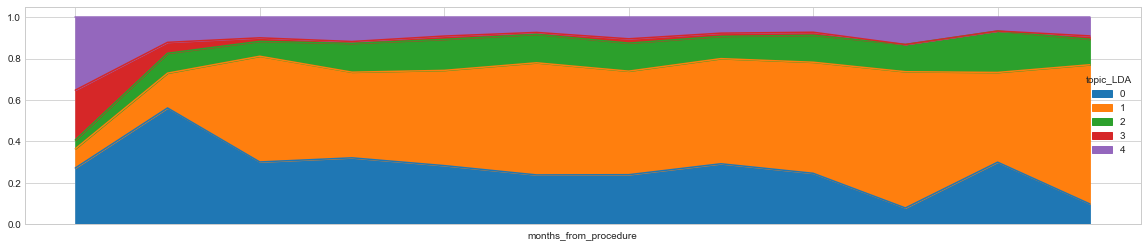

In [419]:
# sns.heatmap(topic_perc, cmap = 'Blues')
#import plotly
#plotly.tools.set_credentials_file(username='nataliabe', api_key='el7xc0JePnGHBNcU6fnl')
#import plotly.plotly as py
#import cufflinks as cf


#topic_perc.iplot(kind='area', fill=True, colors = ['rgba(67,67,67,1)', 'rgba(115,115,115,1)', 'rgba(49,130,189, 1)', 'rgba(189,189,189,1)'])

topic_perc[:18].plot.area(figsize=(20,4))


## Topic-Sentiment Analysis

In [264]:
df_topic0 = df[df['topic_LDA'] == 0]
df_topic1 = df[df['topic_LDA'] == 1]
df_topic2 = df[df['topic_LDA'] == 2]
df_topic3 = df[df['topic_LDA'] == 3]
df_topic4 = df[df['topic_LDA'] == 4]

print("topic 0 ocurrences: {}".format(len(df_topic0)))
print("topic 1 ocurrences: {}".format(len(df_topic1)))
print("topic 2 ocurrences: {}".format(len(df_topic2)))
print("topic 3 ocurrences: {}".format(len(df_topic3)))
print("topic 4 ocurrences: {}".format(len(df_topic4)))

topic 0 ocurrences: 1604
topic 1 ocurrences: 1275
topic 2 ocurrences: 383
topic 3 ocurrences: 628
topic 4 ocurrences: 1097


In [265]:
df_topic0_positive = df_topic0[df_topic0['sentiment'] == 'positive']
df_topic0_negative = df_topic0[df_topic0['sentiment'] == 'negative']
df_topic1_positive = df_topic1[df_topic1['sentiment'] == 'positive']
df_topic1_negative = df_topic1[df_topic1['sentiment'] == 'negative']
df_topic2_positive = df_topic2[df_topic2['sentiment'] == 'positive']
df_topic2_negative = df_topic2[df_topic2['sentiment'] == 'negative']
df_topic3_positive = df_topic3[df_topic3['sentiment'] == 'positive']
df_topic3_negative = df_topic3[df_topic3['sentiment'] == 'negative']
df_topic4_positive = df_topic4[df_topic4['sentiment'] == 'positive']
df_topic4_negative = df_topic4[df_topic4['sentiment'] == 'negative']

topics_sentiment = {"Positive": {"topic 0":len(df_topic0_positive), "topic 1": len(df_topic1_positive), "topic 2": len(df_topic2_positive), "topic 3": len(df_topic3_positive), "topic 4": len(df_topic4_positive)}, "Negative":{"topic 0": len(df_topic0_negative), "topic 1": len(df_topic1_negative), "topic 2": len(df_topic2_negative), "topic 3": len(df_topic3_negative), "topic 4": len(df_topic4_negative)}}

pd.DataFrame(topics_sentiment)

Negative  Positive
topic 0  34        86      
topic 1  16        241     
topic 2  5         27      
topic 3  32        22      
topic 4  44        12

## Get word clouds

In [266]:
topic0_positive = list(df_topic0_positive['body'])
topic0_negative = list(df_topic0_negative['body'])
topic1_positive = list(df_topic1_positive['body'])
topic1_negative = list(df_topic1_negative['body'])
topic2_positive = list(df_topic2_positive['body'])
topic2_negative = list(df_topic2_negative['body'])
topic3_positive = list(df_topic3_positive['body'])
topic3_negative = list(df_topic3_negative['body'])
topic4_positive = list(df_topic4_positive['body'])
topic4_negative = list(df_topic4_negative['body'])

In [267]:
background_color="white"
stopwords_add = stopwords.words('english') + ["treatment", "procedure", "Coolsculpting", "Love", "I'm", "results", "results", "would", "cool", "sculpting", "stomach", "handle", "handles", "still", "lower", "see", "done", "get"]
#stopwords_add = nltk_stopwords
max_font_size=150
max_words=80
width=1000
height=600

In [268]:
wordcloud_topic0_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic0_positive['body']))
wordcloud_topic0_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic0_negative['body']))
wordcloud_topic1_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic1_positive['body']))
wordcloud_topic1_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic1_negative['body']))
wordcloud_topic2_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic2_positive['body']))
wordcloud_topic2_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic2_negative['body']))
wordcloud_topic3_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic3_positive['body']))
wordcloud_topic3_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic3_negative['body']))
wordcloud_topic4_positive = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic4_positive['body']))
wordcloud_topic4_negative = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(df_topic4_negative['body']))

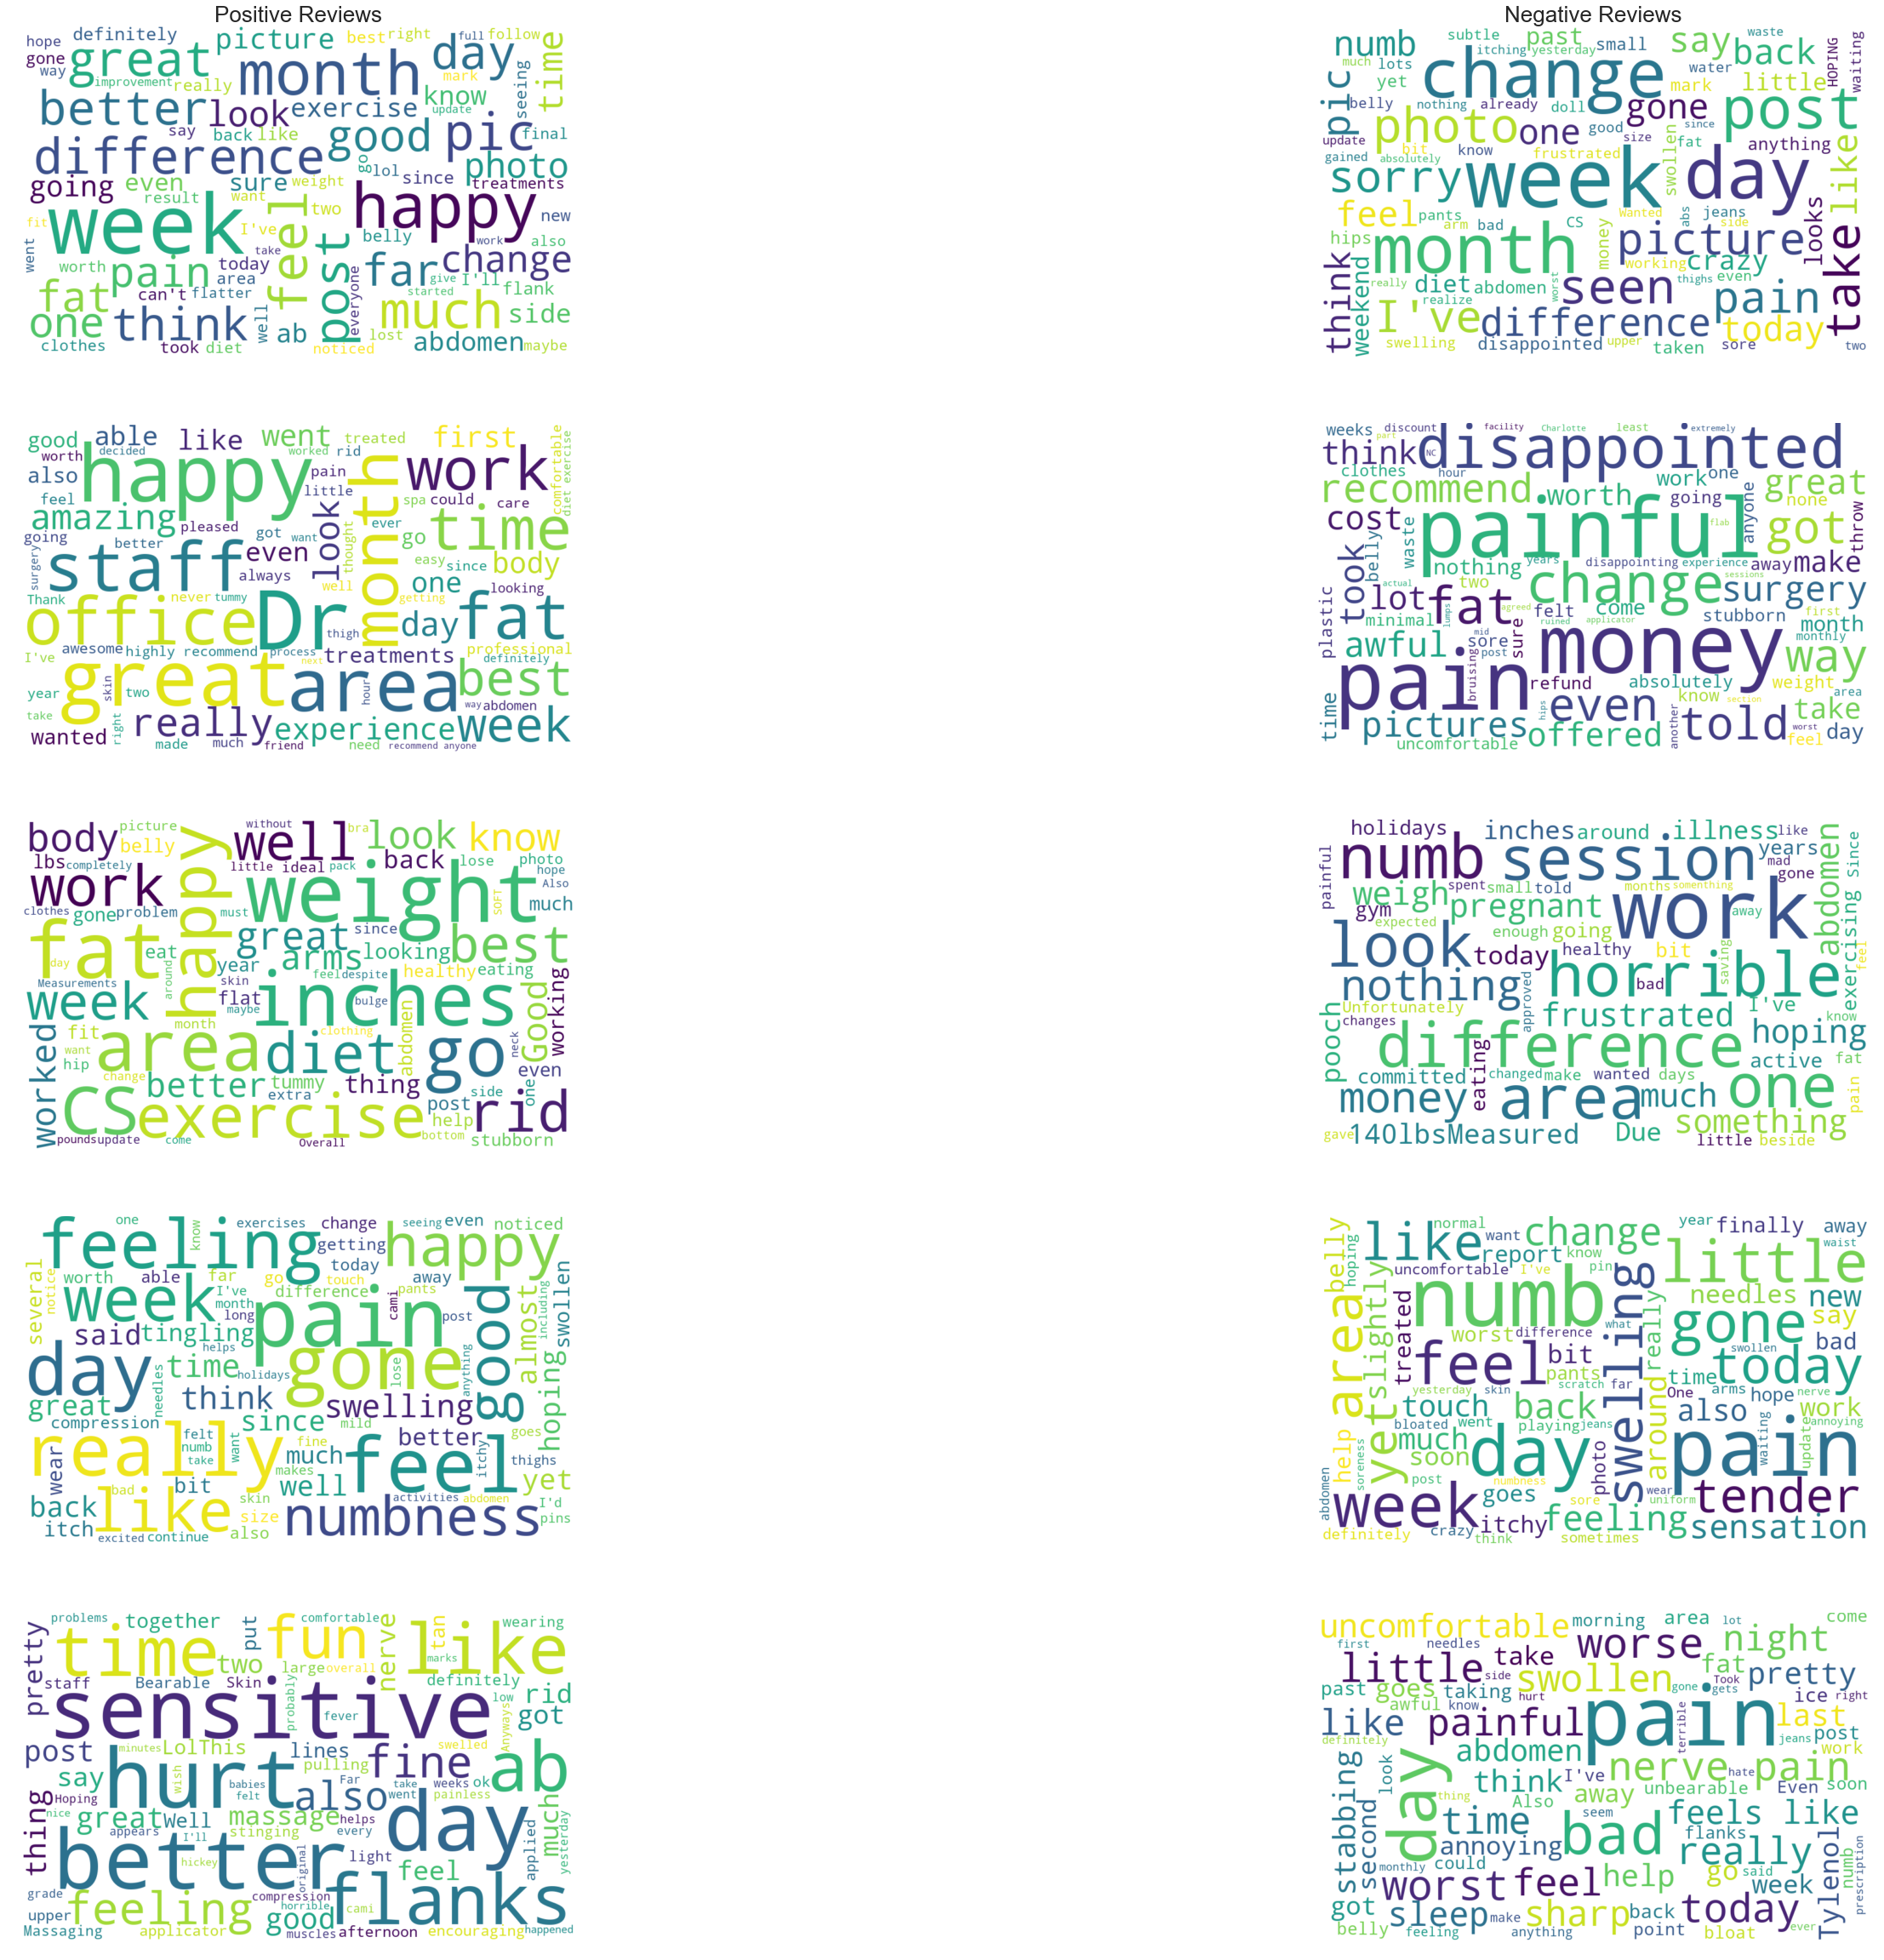

In [269]:
plt.figure(figsize = (50,50))

plt.subplot(6, 2, 1)
plt.imshow(wordcloud_topic0_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Reviews', fontsize=26)

plt.subplot(6, 2, 3)
plt.imshow(wordcloud_topic1_positive, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 5)
plt.imshow(wordcloud_topic2_positive, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 7)
plt.imshow(wordcloud_topic3_positive, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 9)
plt.imshow(wordcloud_topic4_positive, interpolation='bilinear')
plt.axis("off")


plt.subplot(6, 2, 2)
plt.imshow(wordcloud_topic0_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Reviews', fontsize=26)

plt.subplot(6, 2, 4)
plt.imshow(wordcloud_topic1_negative, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 6)
plt.imshow(wordcloud_topic2_negative, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 8)
plt.imshow(wordcloud_topic3_negative, interpolation='bilinear')
plt.axis("off")

plt.subplot(6, 2, 10)
plt.imshow(wordcloud_topic4_negative, interpolation='bilinear')
plt.axis("off")

plt.show()

In [277]:
import operator

count_vect = CountVectorizer(stop_words = nltk_stopwords,
                                       max_df = 0.8, ngram_range = (2,4))
matrix = count_vect.fit_transform(df_topic0_negative['body'])
vocab = count_vect.get_feature_names()

print(count_vect.vocabulary_)

#sorted_x = sorted(count_vect.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
#sorted_x

{'lipo freeze': 492, 'freeze flanks': 372, 'flanks end': 366, 'end april': 319, 'april back': 72, 'back waiting': 88, 'waiting game': 1019, 'game see': 390, 'see give': 796, 'give satified': 399, 'satified may': 755, 'may either': 527, 'either dra': 316, 'dra doll': 299, 'doll yilly': 296, 'yilly doll': 1142, 'doll see': 295, 'lipo freeze flanks': 493, 'freeze flanks end': 373, 'flanks end april': 367, 'end april back': 320, 'april back waiting': 73, 'back waiting game': 89, 'waiting game see': 1020, 'game see give': 391, 'see give satified': 797, 'give satified may': 400, 'satified may either': 756, 'may either dra': 528, 'either dra doll': 317, 'dra doll yilly': 300, 'doll yilly doll': 297, 'yilly doll see': 1143, 'lipo freeze flanks end': 494, 'freeze flanks end april': 374, 'flanks end april back': 368, 'end april back waiting': 321, 'april back waiting game': 74, 'back waiting game see': 90, 'waiting game see give': 1021, 'game see give satified': 392, 'see give satified may': 798

In [319]:
df[df['worthit'] == "Not Worthit"]

Empty DataFrame
Columns: [body, days_from_procedure, doctor, likes, location, post_date, post_title, price, procedure_date, title, username, worthit, treatment, post_year, body_lem, topic_LDA, weeks_from_procedure, biweekly, period, sentences, tokens, sentiment_scores, avg_sentiment, sentiment]
Index: []

[0 rows x 24 columns]

In [324]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, stop_words= nltk_stopwords, ngram_range = (2,3))

tfidf = tfidf_vectorizer.fit_transform(df[df['worthit'] == "Not Worth It"]['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1))
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('00 124', 0),
 ('00 124 pounds', 1),
 ('00 canadian', 2),
 ('00 canadian need', 3),
 ('00 discomfort', 4),
 ('00 discomfort months', 5),
 ('00 discount', 6),
 ('00 discount 500', 7),
 ('00 later', 8),
 ('00 later absolutely', 9),
 ('00 long', 10),
 ('00 long hours', 11),
 ('00 pay', 12),
 ('00 pay even', 13),
 ('00 pounds', 14),
 ('00 pounds 5000', 15),
 ('00 prepaid', 16),
 ('00 prepaid first', 17),
 ('00 sections', 18),
 ('00 sections tummy', 19),
 ('00 though', 20),
 ('00 though seems', 21),
 ('00 thought', 22),
 ('00 thought expensive', 23),
 ('00 told', 24),
 ('00 told tighten', 25),
 ('00 weigh', 26),
 ('00 weigh less', 27),
 ('000 00', 28),
 ('000 00 canadian', 29),
 ('000 00 discomfort', 30),
 ('000 00 later', 31),
 ('000 00 though', 32),
 ('000 000', 33),
 ('000 000 rate', 34),
 ('000 6000', 35),
 ('000 6000 always', 36),
 ('000 90', 37),
 ('000 90 away', 38),
 ('000 also', 39),
 ('000 also took', 40),
 ('000 another', 41),
 ('000 another times', 42),
 ('000 aud', 43),
 ('00

In [285]:
tfidf = tfidf_vectorizer.fit_transform(df_topic0_negative['body'])

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#print (tfidf_vectorizer.vocabulary_)

sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('yilly doll see', 790),
 ('yilly doll', 789),
 ('yet see progress', 788),
 ('yet see', 787),
 ('yet hope waste', 786),
 ('yet hope', 785),
 ('yesterday good picture', 784),
 ('yesterday good', 783),
 ('yesterday crossing fingers', 782),
 ('yesterday crossing', 781),
 ('wow week already', 780),
 ('wow week', 779),
 ('worst part wait', 778),
 ('worst part', 777),
 ('workout yesterday crossing', 776),
 ('workout yesterday', 775),
 ('working working maniac', 774),
 ('working working', 773),
 ('working maniac', 772),
 ('work everyone expensive', 771),
 ('work everyone', 770),
 ('within week bad', 769),
 ('within week', 768),
 ('wish doc says', 767),
 ('wish doc', 766),
 ('whatever gettin frustrated', 765),
 ('whatever gettin', 764),
 ('well today numbness', 763),
 ('well today', 762),
 ('weight week freaking', 761),
 ('weight week', 760),
 ('weeks weeks looks', 759),
 ('weeks weeks', 758),
 ('weeks seen improvement', 757),
 ('weeks seen', 756),
 ('weeks post', 755),
 ('weeks notice anythi

In [286]:
tfidf = tfidf_vectorizer.fit_transform(df_topic1_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('years way think', 644),
 ('years way', 643),
 ('years ago thought', 642),
 ('years ago', 641),
 ('worth money agreeing', 640),
 ('worth money', 639),
 ('worst part absolutely', 638),
 ('worst part', 637),
 ('worse started', 636),
 ('workout regiments strict', 635),
 ('workout regiments', 634),
 ('workman give discount', 633),
 ('workman give', 632),
 ('work resumed exercise', 631),
 ('work resumed', 630),
 ('work refund offered', 629),
 ('work refund', 628),
 ('work 10 hours', 627),
 ('work 10', 626),
 ('weight training awful', 625),
 ('weight training', 624),
 ('weight past years', 623),
 ('weight past', 622),
 ('weeks unable wear', 621),
 ('weeks unable', 620),
 ('weeks afterwards remained', 619),
 ('weeks afterwards', 618),
 ('wear regular clothes', 617),
 ('wear regular', 616),
 ('way think unfair', 615),
 ('way think possible', 614),
 ('way think', 613),
 ('way looked clothes', 612),
 ('way looked', 611),
 ('way going nothing', 610),
 ('way going', 609),
 ('waste money two', 60

In [287]:
tfidf = tfidf_vectorizer.fit_transform(df_topic2_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('years committed going', 124),
 ('years committed', 123),
 ('work mad spent', 122),
 ('work mad', 121),
 ('work look horrible', 120),
 ('work look', 119),
 ('work beside horrible', 118),
 ('work beside', 117),
 ('weigh 140lbs', 116),
 ('wanted gone told', 115),
 ('wanted gone', 114),
 ('unfortunately session make', 113),
 ('unfortunately session', 112),
 ('told session enough', 111),
 ('told session', 110),
 ('today 32 inches', 109),
 ('today 32', 108),
 ('spent money somenthing', 107),
 ('spent money', 106),
 ('something frustrated', 105),
 ('somenthing work', 104),
 ('small wanted gone', 103),
 ('small wanted', 102),
 ('since small wanted', 101),
 ('since small', 100),
 ('session make difference', 99),
 ('session make', 98),
 ('session enough painful', 97),
 ('session enough', 96),
 ('see know approved', 95),
 ('see know', 94),
 ('saving months see', 93),
 ('saving months', 92),
 ('pregnant hoping something', 91),
 ('pregnant hoping', 90),
 ('pooch today 32', 89),
 ('pooch today', 

In [289]:
tfidf = tfidf_vectorizer.fit_transform(df_topic3_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('yet thanks support', 793),
 ('yet thanks', 792),
 ('yet also numb', 791),
 ('yet also', 790),
 ('yesturday worst hope', 789),
 ('yesturday worst', 788),
 ('yesterday itches think', 787),
 ('yesterday itches', 786),
 ('yesterday got back', 785),
 ('yesterday got', 784),
 ('year weekend finally', 783),
 ('year weekend', 782),
 ('year parents house', 781),
 ('year parents', 780),
 ('worst new year', 779),
 ('worst new', 778),
 ('worst hope stays', 777),
 ('worst hope', 776),
 ('worst days ached', 775),
 ('worst days', 774),
 ('working vigorously days', 773),
 ('working vigorously', 772),
 ('work vacation hardest', 771),
 ('work vacation', 770),
 ('work crazy sometimes', 769),
 ('work crazy', 768),
 ('work ab glider', 767),
 ('work ab', 766),
 ('woke today horrible', 765),
 ('woke today', 764),
 ('well far feeling', 763),
 ('well far', 762),
 ('weird sensations gone', 761),
 ('weird sensations', 760),
 ('weeks weird sensations', 759),
 ('weeks weird', 758),
 ('weeks swelling gone', 757)

In [290]:
tfidf = tfidf_vectorizer.fit_transform(df_topic4_negative['body'])
#print (tfidf_vectorizer.vocabulary_)

import operator
sorted_x = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse = True)
sorted_x

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('zeltiq april prepared', 1887),
 ('zeltiq april', 1886),
 ('yuck bloat poop', 1885),
 ('yuck bloat', 1884),
 ('yet swear miserable', 1883),
 ('yet swear', 1882),
 ('yet 10 hold', 1881),
 ('yet 10', 1880),
 ('yesterday nerve hit', 1879),
 ('yesterday nerve', 1878),
 ('years running business', 1877),
 ('years running', 1876),
 ('years ago bringing', 1875),
 ('years ago', 1874),
 ('yah come time', 1873),
 ('yah come', 1872),
 ('wrote prescription neurontin', 1871),
 ('wrote prescription', 1870),
 ('wrong guys think', 1869),
 ('wrong guys', 1868),
 ('wow told hurt', 1867),
 ('wow told', 1866),
 ('worth yet swear', 1865),
 ('worth yet', 1864),
 ('worth days constant', 1863),
 ('worth days', 1862),
 ('worth always counting', 1861),
 ('worth always', 1860),
 ('worst stabbing nerve', 1859),
 ('worst stabbing', 1858),
 ('worst seems goes', 1857),
 ('worst seems', 1856),
 ('worst ready away', 1855),
 ('worst ready', 1854),
 ('worst part massage', 1853),
 ('worst part', 1852),
 ('worst night ye

In [316]:
df_not_worthit.groupby(['topic_notworthit', 'body']).count()

days_from_procedure  \
topic_notworthit body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    23                    
                 1/7/14 will be my 4th month after coolsculpting. I don't notice any changes. In fact, my pants are now tigheter but I know that 

In [313]:
df_not_worthit.groupby(['topic_notworthit']).count().reset_index()[['topic_notworthit', 'body']]

topic_notworthit  body
0  0                 142 
1  1                 13  
2  2                 661 
3  3                 80

In [301]:
not_worthit0 = list(df_not_worthit[df_not_worthit['topic_notworthit'] == 0]['body'])
not_worthit1 = list(df_not_worthit[df_not_worthit['topic_notworthit'] == 1]['body'])
not_worthit2 = list(df_not_worthit[df_not_worthit['topic_notworthit'] == 2]['body'])
not_worthit3 =  list(df_not_worthit[df_not_worthit['topic_notworthit'] == 3]['body'])

In [302]:
wordcloud_not_worthit0 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit0))
wordcloud_not_worthit1 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit1))
wordcloud_not_worthit2 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit2))
wordcloud_not_worthit3 = WordCloud(background_color="white", stopwords=stopwords_add, max_font_size=max_font_size, max_words=max_words, width=width, height=height).generate(''.join(not_worthit3))

(-0.5, 999.5, 599.5, -0.5)

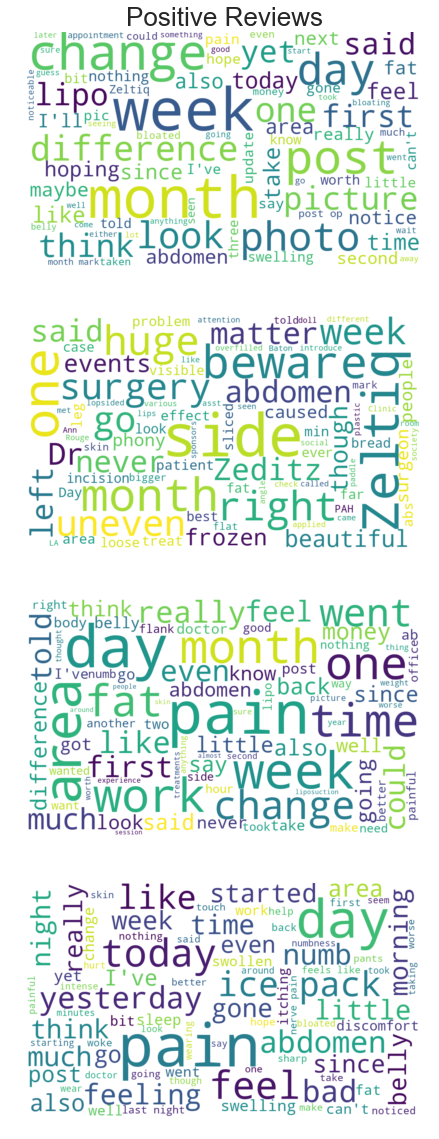

In [306]:
plt.figure(figsize = (20,20))

plt.subplot(4, 1, 1)
plt.imshow(wordcloud_not_worthit0, interpolation='bilinear')
plt.axis("off")

plt.subplot(4, 1, 2)
plt.imshow(wordcloud_not_worthit1, interpolation='bilinear')
plt.axis("off")

plt.subplot(4, 1, 3)
plt.imshow(wordcloud_not_worthit2, interpolation='bilinear')
plt.axis("off")

plt.subplot(4, 1, 4)
plt.imshow(wordcloud_not_worthit3, interpolation='bilinear')
plt.axis("off")


In [326]:
X_negative = [x for x in df_not_worthit['body']]

In [348]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, max_features=no_features, stop_words= nltk_stopwords, ngram_range=(2, 4))


    
tfidf = tfidf_vectorizer.fit_transform(df_not_worthit['body'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nmf = NMF(n_components=4, random_state=111, alpha=.1, l1_ratio=.5, init='nndsvd')
X_negative_reduced = nmf.fit_transform(tfidf)
components = nmf.components_
print(components)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.03232723 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/Pattern-2.6-py3.6.egg/pattern/text/en/../../../../sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [349]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('waste money', 1.9892286919686524), ('tummy tuck', 0.23209413009287097), ('total waste money', 0.17872496808834196), ('absolutely change', 0.1716628006554884), ('total waste', 0.16320832187324716), ('months since', 0.14013579040048718), ('two procedures', 0.13227482942196217), ('please waste', 0.1288176683241701), ('month follow', 0.10935090005479385), ('anything yet', 0.10926675198136496), ('came back', 0.10563569571864435), ('seems work', 0.10037011093940663), ('complete waste', 0.07812102748031582), ('ideal image', 0.07717565730866667), ('lot money', 0.07525949470795329), ('took money', 0.0681075096067716), ('money disappointed', 0.06642949781133842), ('saw zero', 0.06533150583914532), ('money paid', 0.064200980379879), ('make sure', 0.05116168757415214)] 

topic 1
[('last night', 1.2108006475036084), ('first time', 1.1798329457148902), ('wearing spanx', 0.268048368865076), ('non stop', 0.15504495233294144), ('even though', 0.13985996677513488), ('last night sleep', 0.1197

In [359]:
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, init="k-means++", random_state=824)
kmeans.fit(X_negative_reduced)
negative_labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))
print("Silhouette score: {}".format(silhouette_score(X_negative_reduced, negative_labels, metric='euclidean', sample_size=5000, random_state=824))) #memory error

Inertia score: 2.2188511426286084
Silhouette score: 0.852613592226237


In [360]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=824)
tsne_negative = tsne.fit_transform(X_negative_reduced)

In [361]:
df_tsne_negative = pd.DataFrame(tsne_negative, columns=["tsne_x", "tsne_y"])
df_tsne_negative.shape

(896, 2)

In [362]:
df_tsne_negative["Cluster"] = negative_labels
df_tsne_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 3 columns):
tsne_x     896 non-null float32
tsne_y     896 non-null float32
Cluster    896 non-null int32
dtypes: float32(2), int32(1)
memory usage: 10.6 KB


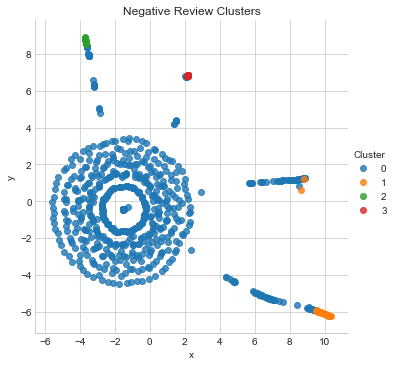

In [363]:
# visualize the negative review clusters using t-SNE
tsne_negative = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_negative, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Negative Review Clusters");

In [396]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#data = pd.read_csv('../input/train.csv').sample(50000, random_state=23)
data = df_not_worthit

In [397]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    data['body'] = data['body'].apply(clean_sentence)
    
    return data

data = clean_dataframe(data)
data.head(5)

<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \s
<input>:5: Dep

body  \
9   wanted get rid noticeable pouch abdominal area prepaid 6 areascycles cost 3200  found difficult get appointment see improvement still experiences numbness procedure would recommend place one seemed concerned difficulties experiencing procedure                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
16  optimistic procedure excited time exposing danger going bought 10 sessions looking forward new improved stomach done first two sessions large applicator painful felt fine whole procedure side effects yes cold numbing stomach unbearable massage painful left waist trainer type body suit swelling bruising following procedure told take 12 weeks see results common see results soon 48 weeks next week arms experience stomach excited finally going kind arms would look great strapless dress waited waited waited nothing took pictures office measurements took measurements records get results stomach area arms felt like scammed money spent wasted nothing two sessions arms left decided get refund two sessions since get results waste hard earned money remember 4 kids finally spent money something necessary something would make look better feel better always put children first put something like money go towards something valuable like college company used going uncharge 8 procedures since got discount 10 refund difference left would like 310 going unfair charge procedure 0 results company finally agreed refund full cost two sessions cancelling get refund offer retreat 8 sessions paid 0 results get follow call dissatisfaction would recommend procedure save money   
17  decided take plunge reading lot reviews took large package save one time costs typically 750 treatment hoping best\n             \n\n             1200 calorie day diet started diet 191 lbs first day treatment 184 lbs picture\n             \n\n\n             told wont lose weight procedure seen enough reviews confident attractive part procedure lack scarring meaning results natural possible\n             \n\n\n             day first procedure bloated hoping best god speed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
18  july 18th 2016 first treatment lower abdomin\n             \n\n             scary feeling sucked machine gets becomes numb fine\n             \n\n             fat 

In [398]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data['body'].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

[['wanted',
  'get',
  'rid',
  'noticeable',
  'pouch',
  'abdominal',
  'area',
  'prepaid',
  '6',
  'areascycles',
  'cost',
  '3200',
  '',
  'found',
  'difficult',
  'get',
  'appointment',
  'see',
  'improvement',
  'still',
  'experiences',
  'numbness',
  'procedure',
  'would',
  'recommend',
  'place',
  'one',
  'seemed',
  'concerned',
  'difficulties',
  'experiencing',
  'procedure'],
 ['optimistic',
  'procedure',
  'excited',
  'time',
  'exposing',
  'danger',
  'going',
  'bought',
  '10',
  'sessions',
  'looking',
  'forward',
  'new',
  'improved',
  'stomach',
  'done',
  'first',
  'two',
  'sessions',
  'large',
  'applicator',
  'painful',
  'felt',
  'fine',
  'whole',
  'procedure',
  'side',
  'effects',
  'yes',
  'cold',
  'numbing',
  'stomach',
  'unbearable',
  'massage',
  'painful',
  'left',
  'waist',
  'trainer',
  'type',
  'body',
  'suit',
  'swelling',
  'bruising',
  'following',
  'procedure',
  'told',
  'take',
  '12',
  'weeks',
  'see'

In [400]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['belly']

2018-03-08 21:37:47,339 : INFO : collecting all words and their counts
2018-03-08 21:37:47,342 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-08 21:37:47,355 : INFO : collected 6345 word types from a corpus of 70734 raw words and 873 sentences
2018-03-08 21:37:47,359 : INFO : Loading a fresh vocabulary
2018-03-08 21:37:47,363 : INFO : min_count=200 retains 38 unique words (0% of original 6345, drops 6307)
2018-03-08 21:37:47,365 : INFO : min_count=200 leaves 29723 word corpus (42% of original 70734, drops 41011)
2018-03-08 21:37:47,368 : INFO : deleting the raw counts dictionary of 6345 items
2018-03-08 21:37:47,370 : INFO : sample=0.001 downsamples 38 most-common words
2018-03-08 21:37:47,373 : INFO : downsampling leaves estimated 5368 word corpus (18.1% of prior 29723)
2018-03-08 21:37:47,375 : INFO : estimated required memory for 38 words and 100 dimensions: 49400 bytes
2018-03-08 21:37:47,378 : INFO : resetting layer weights
2018-03-08 21:37:47,3

array([-2.11739037e-02,  5.31928567e-03, -1.45964295e-01, -1.22741528e-01,
       -9.47940275e-02, -5.41112311e-02,  1.04175784e-01,  3.74213420e-02,
        7.16937259e-02, -9.45725217e-02,  3.01926173e-02, -7.98167363e-02,
       -7.38451863e-03, -1.84098229e-01,  1.19260564e-01, -9.80656408e-03,
       -4.85874079e-02, -1.77241668e-01,  5.50631806e-02,  8.14372972e-02,
        1.54296383e-01, -2.65603866e-02,  9.02037770e-02,  8.53269696e-02,
        6.93101212e-02, -4.90845647e-03, -7.30796978e-02,  4.43212129e-03,
       -1.74198762e-01, -1.82290509e-01,  3.07779685e-02,  6.09924970e-03,
        1.48783892e-01,  9.48939100e-02, -8.65362734e-02, -6.62169382e-02,
       -1.30307406e-01,  1.17514208e-01,  9.66288745e-02,  1.23863809e-01,
       -7.53140301e-02,  1.15885898e-01, -1.31416813e-01,  2.65943594e-02,
        1.10240154e-01,  8.82031694e-02, -1.00544214e-01, -6.66417852e-02,
        2.37055216e-02,  4.29840200e-02, -1.08639017e-01, -1.08971119e-01,
       -4.03988957e-02, -

In [401]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call t

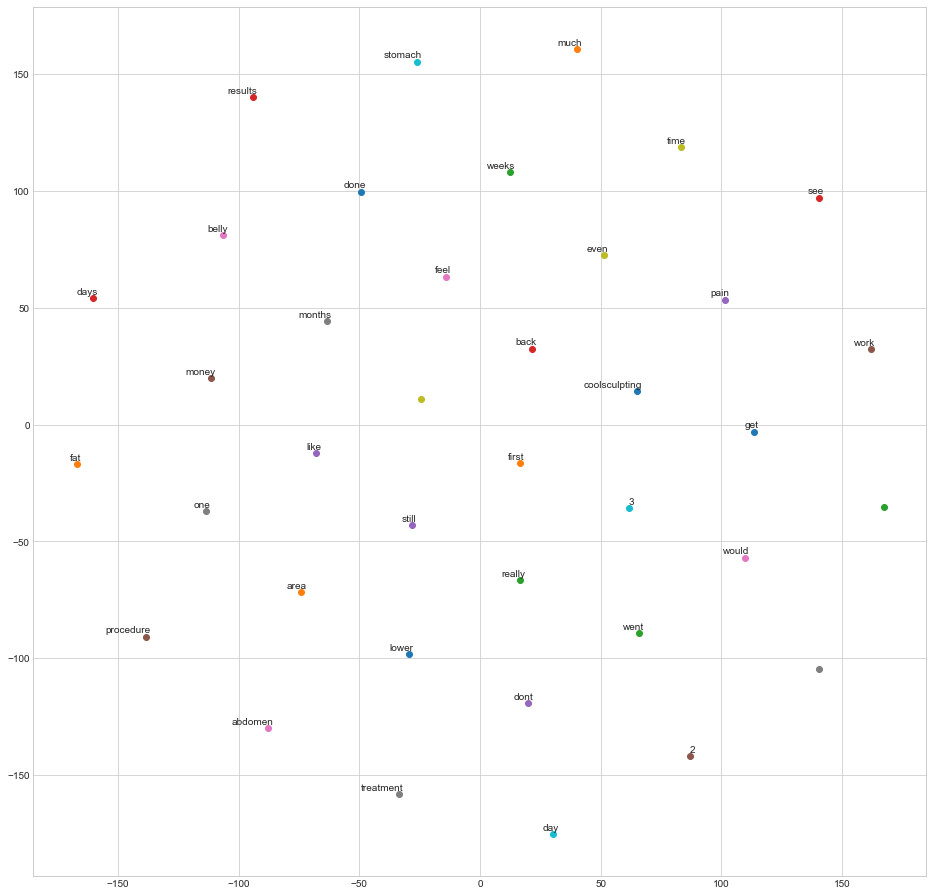

In [402]:
tsne_plot(model)

2018-03-08 21:39:18,244 : INFO : collecting all words and their counts
2018-03-08 21:39:18,247 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-08 21:39:18,260 : INFO : collected 6345 word types from a corpus of 70734 raw words and 873 sentences
2018-03-08 21:39:18,263 : INFO : Loading a fresh vocabulary
2018-03-08 21:39:18,267 : INFO : min_count=100 retains 90 unique words (1% of original 6345, drops 6255)
2018-03-08 21:39:18,269 : INFO : min_count=100 leaves 36984 word corpus (52% of original 70734, drops 33750)
2018-03-08 21:39:18,271 : INFO : deleting the raw counts dictionary of 6345 items
2018-03-08 21:39:18,273 : INFO : sample=0.001 downsamples 90 most-common words
2018-03-08 21:39:18,275 : INFO : downsampling leaves estimated 11773 word corpus (31.8% of prior 36984)
2018-03-08 21:39:18,277 : INFO : estimated required memory for 90 words and 100 dimensions: 117000 bytes
2018-03-08 21:39:18,279 : INFO : resetting layer weights
2018-03-08 21:39:18

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call t

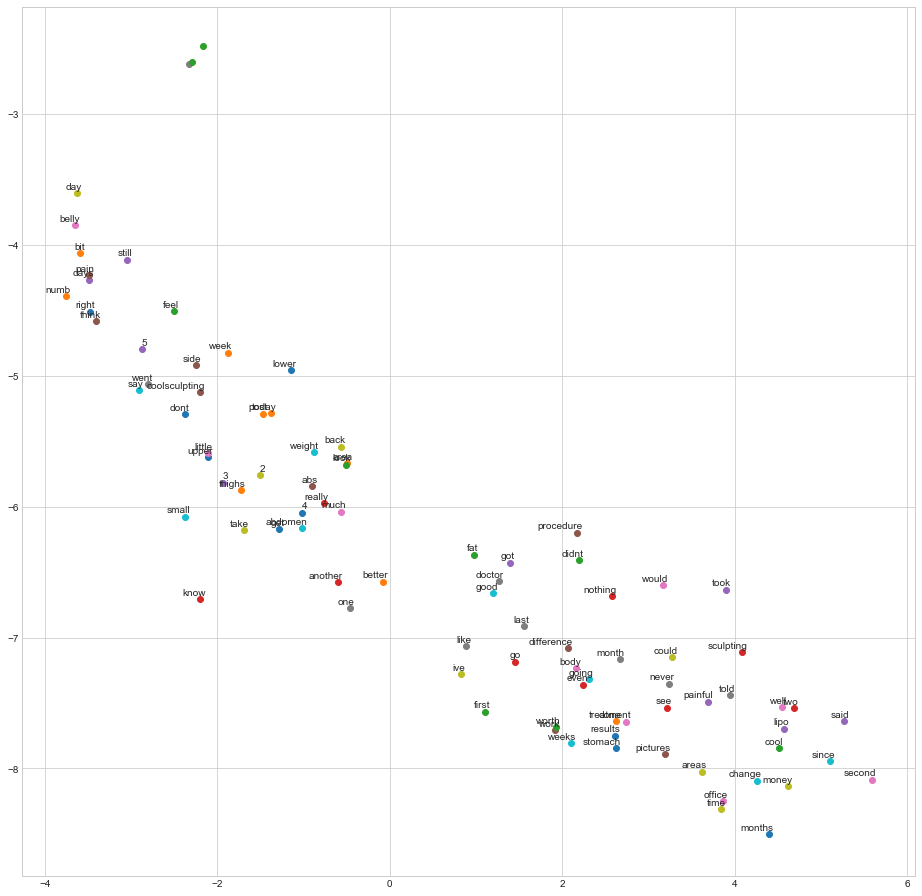

In [403]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
tsne_plot(model)